# Import des Librairies utiles au projet

In [411]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from numpy.random import RandomState
import scipy.stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

# A partir des différents datasets à notre disposition sur les courses de Formule 1, comment peut-on prédire quelle écurie gagnera la course ?

### Le dataset que nous avons utilisé est disponible à l'adresse suivante : https://www.kaggle.com/datasets/melissamonfared/formula-1/data
Les données que nous possédons proviennet de multiples jeux de données aux facteurs variés. Chacun d'entre eux contient des informations qu peuvent nous être utiles pour prédire le résultat de la course.

Notre jeu de données contient les csv suivants :
 1. Circuits
 2. Constructor results
 3. Constructor standings
 4. Constructors
 5. drivers
 6. driver standings
 7. Lap times
 8. Pit stops
 9. Qualifying
 10. Races
 11. Results
 12. Seasons
 13. Sprint results
 14. Status

Avant de passer à l'entraînement de notre model, il nous faut déjà visualiser une première fois nos données, pour identifier les variables qui ont le plus d'impacts, si certaines colonnes sont vides, si certaines données sont inutilisables, etc... Cette étape nous aidera à faire les démarches nécessaires au nettoyage de notre dataset afin qu'il soit le plus performant possible.

In [412]:
# Lecture rapide des csv

circuits_df = pd.read_csv('circuits.csv')
print("Circuits :\n", circuits_df.head())

constructor_results_df = pd.read_csv('constructor_results.csv')
print("Constructor_results :\n",constructor_results_df.head())

constructor_standings_df = pd.read_csv('constructor_standings.csv')
print("Constructor_standings :\n",constructor_standings_df.head())

constructors_df = pd.read_csv('constructors.csv')
print("Constructors :\n",constructors_df.head())

driver_standings_df = pd.read_csv('driver_standings.csv')
print("Driver_standings :\n",driver_standings_df.head())

drivers_df = pd.read_csv('drivers.csv')
print("Drivers :\n",drivers_df.head())

lap_times_df = pd.read_csv('lap_times.csv')
print("Lap_times :\n",lap_times_df.head())

pit_stops_df = pd.read_csv('pit_stops.csv')
print("Pit_stops :\n",pit_stops_df.head())

qualifying_df = pd.read_csv('qualifying.csv')
print("Qualifying :\n",qualifying_df.head())

races_df = pd.read_csv('races.csv')
print("Races :\n",races_df.head())

results_df = pd.read_csv('results.csv')
print("Results :\n",results_df.head())

seasons_df = pd.read_csv('seasons.csv')
print("Seasons :\n",seasons_df.head())

sprint_results_df = pd.read_csv('sprint_results.csv')
print("Sprint_results :\n",sprint_results_df.head())

status_df = pd.read_csv('status.csv')
print("Status :\n",status_df.head())

Circuits :
    circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya      Montmeló   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat        lng  alt  \
0  Australia -37.84970  144.96800   10   
1   Malaysia   2.76083  101.73800   18   
2    Bahrain  26.03250   50.51060    7   
3      Spain  41.57000    2.26111  109   
4     Turkey  40.95170   29.40500  130   

                                                 url  
0  http://en.wikipedia.org/wiki/Melbourne_Grand_P...  
1  http://en.wikipedia.org/wiki/Sepang_Internatio...  
2  http://en.wikipedia.org/wiki/Bahrain_Internati...  
3  http://en.wikipedia.org/wiki/Circuit_de_Barcel...  
4        

# Audit de la qualité des données (Missing Values)

Ici nous regardons quelles sont les proportions de valeurs nulles et aux caractères spéciaux ('\\N') afin de s'en charger à l'avenir dans le preprocessing.

In [413]:
def audit_data_quality(dataframes_dict):
    """Vérifie les valeurs manquantes et les caractères spéciaux comme '\\N'."""
    print("--- Rapport de Qualité des Données ---")
    for name, df in dataframes_dict.items():
        print(f"\nJeu de données : {name.upper()}")
        print(f"Dimensions : {df.shape}")
        
        # Vérifier les NaN standards
        na_count = df.isna().sum().sum()
        
        # Vérifier les '\N' spécifiques à ce dataset Kaggle
        n_str_count = (df == '\\N').sum().sum()
        
        if na_count > 0 or n_str_count > 0:
            print(f"Valeurs NaN : {na_count}")
            print(f"Valeurs '\\N' : {n_str_count}")
            # Afficher les colonnes concernées
            cols_missing = df.columns[(df == '\\N').any() | df.isna().any()].tolist()
            print(f"Colonnes à nettoyer : {cols_missing}")
        else:
            print("Aucune valeur manquante détectée.")

audit_data_quality({
    'circuits': circuits_df,
    'constructor_results': constructor_results_df,
    'constructor_standings': constructor_standings_df,
    'constructors': constructors_df,
    'driver_standings': driver_standings_df,
    'drivers': drivers_df,
    'lap_times': lap_times_df,
    'pit_stops': pit_stops_df,
    'qualifying': qualifying_df,
    'races': races_df,
    'results': results_df,
    'seasons': seasons_df,
    'sprint_results': sprint_results_df,
    'status': status_df
})

--- Rapport de Qualité des Données ---

Jeu de données : CIRCUITS
Dimensions : (77, 9)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTOR_RESULTS
Dimensions : (12495, 5)
Valeurs NaN : 0
Valeurs '\N' : 12478
Colonnes à nettoyer : ['status']

Jeu de données : CONSTRUCTOR_STANDINGS
Dimensions : (13261, 7)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTORS
Dimensions : (212, 5)
Aucune valeur manquante détectée.

Jeu de données : DRIVER_STANDINGS
Dimensions : (34574, 7)
Aucune valeur manquante détectée.

Jeu de données : DRIVERS
Dimensions : (859, 9)
Valeurs NaN : 0
Valeurs '\N' : 1559
Colonnes à nettoyer : ['number', 'code']

Jeu de données : LAP_TIMES
Dimensions : (575029, 6)
Aucune valeur manquante détectée.

Jeu de données : PIT_STOPS
Dimensions : (10945, 7)
Aucune valeur manquante détectée.

Jeu de données : QUALIFYING
Dimensions : (10234, 9)
Valeurs NaN : 40
Valeurs '\N' : 11424
Colonnes à nettoyer : ['q1', 'q2', 'q3']

Jeu de données : RACES
Dimensions : (1

Après cette première analyse rapide, nous nous appercevons que certains datasets contiennent de nombreuses colonnes aux données manquantes, certaines l'étant presque complètement (comme status avec 12478 nulls pour 12495 lignes). Il nous faudra donc traiter ces cas plus en profondeur en supprimant les lignes concernées par exemple ou en utilisant des techniques de Feature Engineering.

Nous allons commencer notre analyse de données en procédant à quelques analyses univariées et visualisations nous permettant de regarder un peu plus en profondeur nos données et d'en tirer de premières conclusions quand à leurs utilités sur notre modèle. Cela nous permettra également de procéder à une première étape de nettoyage.

### Extraction des datasets

Dans le script suivant nous automatisons  le chargement des 14 fichiers CSV en convertissant le symbole spécifique \N en données nulles (NaN). Cette étape est indispensable pour que la librairie Pandas reconnaisse nos données comme des nombres et non du texte. 
Ensuite nous extrayons ces données de notre dictionnaire vers des variables distinctes (comme results ou drivers) pour simplifier leur utilisation immédiate.

In [414]:
dataframes = {}
file_names = [
    "circuits.csv", "constructor_results.csv", "constructor_standings.csv",
    "constructors.csv", "driver_standings.csv", "drivers.csv",
    "lap_times.csv", "pit_stops.csv", "races.csv", "results.csv", "status.csv", 
    "qualifying.csv", "seasons.csv", "sprint_results.csv"
]
na_val = '\\N'

for f_name in file_names:
    try:
        key = f_name.split('.')[0]
        dataframes[key] = pd.read_csv(f_name, na_values=[na_val])
        print(f"Fichier '{f_name}' chargé.")
    except FileNotFoundError:
        # En cas de mauvaise écriture du csv ou non présence des fichiers dans le bon dossier
        print(f"ERREUR INATTENDUE : Fichier non trouvé : '{f_name}'")
        sys.exit()

#Extraire les datasets
results = dataframes.get('results')
races = dataframes.get('races')
circuits = dataframes.get('circuits')
drivers = dataframes.get('drivers')
constructors = dataframes.get('constructors')
driver_standings = dataframes.get('driver_standings')
constructor_standings = dataframes.get('constructor_standings')
constructor_results = dataframes.get('constructor_results')
status = dataframes.get('status')
lap_times = dataframes.get('lap_times')
pit_stops = dataframes.get('pit_stops')
status = dataframes.get('status')
qualifying = dataframes.get('qualifying')
seasons = dataframes.get('seasons')
sprint_results = dataframes.get('sprint_results')

Fichier 'circuits.csv' chargé.
Fichier 'constructor_results.csv' chargé.
Fichier 'constructor_standings.csv' chargé.
Fichier 'constructors.csv' chargé.
Fichier 'driver_standings.csv' chargé.
Fichier 'drivers.csv' chargé.
Fichier 'lap_times.csv' chargé.
Fichier 'pit_stops.csv' chargé.
Fichier 'races.csv' chargé.
Fichier 'results.csv' chargé.
Fichier 'status.csv' chargé.
Fichier 'qualifying.csv' chargé.
Fichier 'seasons.csv' chargé.
Fichier 'sprint_results.csv' chargé.


# Analyse Univariée et premiers nettoyages

Configuration du style pour les diagrammes, graphes et autres schémas utilisées pour la visualisation.

In [415]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)

### Analyse des colonnes urls, lat, lng, alt, location et country de circuits

Dans ce dataset on remarque plusieurs colonnes qui ont l'air de ne pas apporter beaucoup d'informations pertinentes, ou contribuent même à de la redondance et à du bruit. Afin d'évaluer cela nous avons procédé à plusieurs visualisations de ces features pour en déduire, ou non, une certaine pertinence.

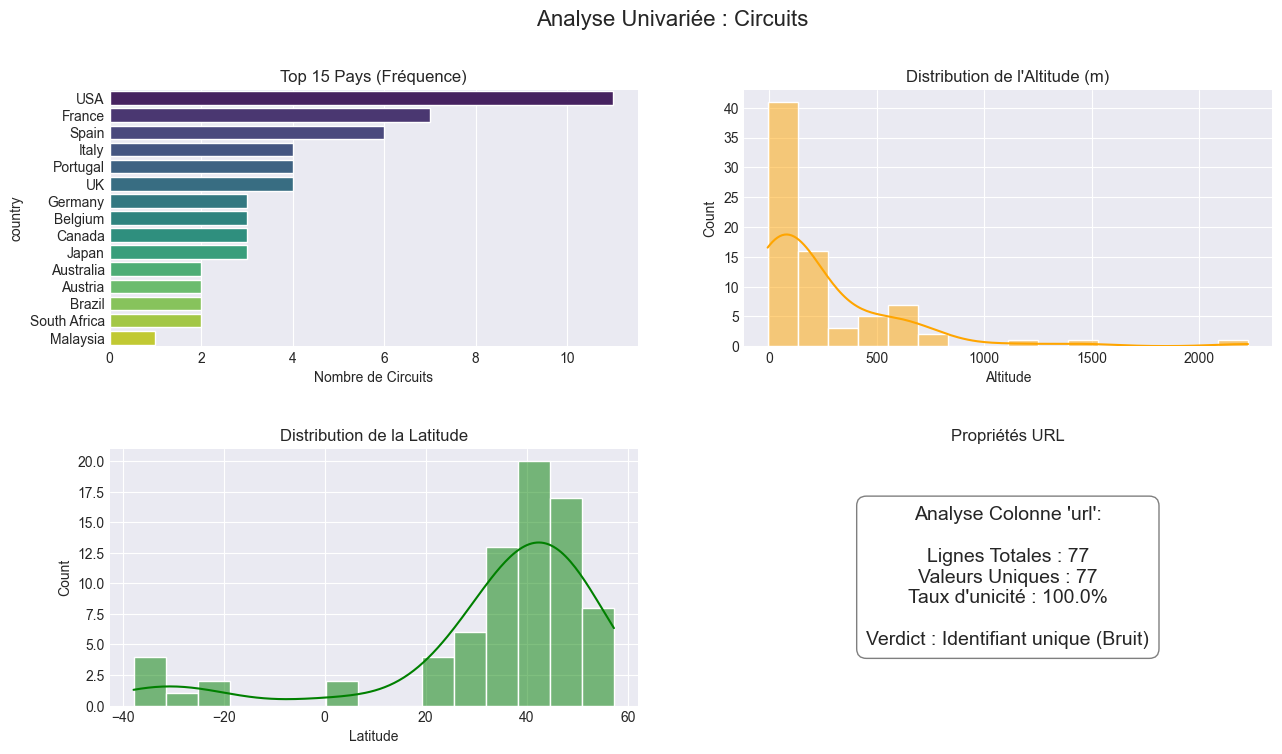

--- Statistiques Descriptives (Altitudes et Latitudes) ---
               alt        lat
count    77.000000  77.000000
mean    247.012987  33.442925
std     362.738469  22.808866
min      -7.000000 -37.849700
25%      18.000000  32.777400
50%     129.000000  40.951700
75%     332.000000  46.958900
max    2227.000000  57.265300


In [416]:
# Création des sous-graphiques
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.4)

# 1. Country (Top 15 pour lisibilité)
country_counts = circuits['country'].value_counts().head(15)
sns.barplot(x=country_counts.values, y=country_counts.index, hue=country_counts.index, legend=False, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Top 15 Pays (Fréquence)')
axes[0, 0].set_xlabel('Nombre de Circuits')

# 2. Altitude (Distribution Physique)
sns.histplot(circuits['alt'].dropna(), kde=True, ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Distribution de l\'Altitude (m)')
axes[0, 1].set_xlabel('Altitude')

# 3. Latitude (Distribution Géographique)
sns.histplot(circuits['lat'], kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Distribution de la Latitude')
axes[1, 0].set_xlabel('Latitude')

# 4. URL (Analyse de Cardinalité)
unique_urls = circuits['url'].nunique()
total_rows = len(circuits)
url_info = (f"Analyse Colonne 'url':\n\n"
            f"Lignes Totales : {total_rows}\n"
            f"Valeurs Uniques : {unique_urls}\n"
            f"Taux d'unicité : {(unique_urls/total_rows)*100:.1f}%\n\n"
            f"Verdict : Identifiant unique (Bruit)")

axes[1, 1].text(0.5, 0.5, url_info, ha='center', va='center', fontsize=14, 
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.5))
axes[1, 1].axis('off')
axes[1, 1].set_title('Propriétés URL')

plt.suptitle('Analyse Univariée : Circuits', fontsize=16)
plt.show()

# Affichage des statistiques numériques
print("--- Statistiques Descriptives (Altitudes et Latitudes) ---")
print(circuits[['alt', 'lat']].describe())

#### Les graphiques et statistiques ci-dessus sont plutôt parlants :

Concernant les pays (en haut à gauche), on peut visualiser aisément que les Etats-Unis, la France ainsi que l'Espagne dominent en nombre de circuits historiques.
Cette colonne peut être intéressante à garder puisqu'il pourrait être intéressant s'il est possible de visualiser dans les victoires des pilotes locaux un "effet domicile". Nous décidons donc de garder cette variable pour le moment.

Cependant, la variable "location" indiquant la ville dans laquelle se trouve le circuit n'apporte rien de plus. Sans avoir besoin de vérifier la disparité nous avons donc décidé de la retirer.

In [417]:
circuits.drop(columns=['location'], inplace=True, errors='ignore')

Pour ce qui est de l'altitude (en haut à droite), on remarque sur le graphique un  point extrême à plus de 2200m. Cela correspond au circuit de Mexico. La plupart des courses se trouvant au niveau de la mer (0-200m), on en déduit que les quelques courses en altitude (Autriche, Brésil, et surtout Mexique) créent des conditions physiques radicalement différentes à cause de la raréfication de l'air.
Ainsi, les performances des écuries ne seront vraisemblablement pas les mêmes car les configurations techniques des véhicules sont plus ou moins adaptées aux fortes et basses altitudes. Cette caractéristique est donc à conserver.

Pour les latitudes (en bas à gauche), on observe une distribution très concentrée entre 30° et 50° Nord. Cela correspond à l'Europe et aux Etats-Unis ce qui valide notre réflexion précédente sur l'étude univariée des pays. L'utilité de cette variable est plutôt faible puisqu'elle ne sert qu'à indiquer que la F1 est un sport euro-centré. Cela n'explique en rien les performances du constructeur et est plutôt redondant puisque nous connaissons déjà les pays dans lesquels se trouvent les circuits.

Il en va de même pour les longitudes.

Nous pouvons donc les supprimer.



In [418]:
circuits.drop(columns=['lat'], inplace=True, errors='ignore')
circuits.drop(columns=['lng'], inplace=True, errors='ignore')

Enfin, concernant les urls (en bas à droite), ce sont des identifiants uniques (puisque l'on observe un taux de 100% d'unicité) qui ne sont là que de manière informative. Pour notre modèle statistique ce n'est que du bruit pur. Ainsi il nous faut retirer cette colonne.

Sans analyse supplémentaire nécessaire, nous nous doutons que la pertinence de cette variable est la même dans chacun des jeux de données. Ainsi, nous éliminons cette colonne dans chacun des csvs qui la contient.

In [419]:
races.drop(columns=['url'], inplace=True, errors='ignore')
drivers.drop(columns=['url'], inplace=True, errors='ignore')
constructors.drop(columns=['url'], inplace=True, errors='ignore')
circuits.drop(columns=['url'], inplace=True, errors='ignore')
seasons.drop(columns=['url'], inplace=True, errors='ignore')

Une dernière colonne nécessitant un nettoyage est circuitRef puisque ce n'est qu'une version redondante de circuitId également illisible par notre modèle et donc inutile. 

In [420]:
circuits.drop(columns=['circuitRef'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [421]:
print("Circuits :\n", circuits.head())

Circuits :
    circuitId                            name    country  alt
0          1  Albert Park Grand Prix Circuit  Australia   10
1          2    Sepang International Circuit   Malaysia   18
2          3   Bahrain International Circuit    Bahrain    7
3          4  Circuit de Barcelona-Catalunya      Spain  109
4          5                   Istanbul Park     Turkey  130


### Analyse des lignes vides de la colonne status de constructors_results

Dans notre première analyse sur la qualité de nos datasets, nous avions remarqué que la colonne status de notre fichier constructors_results.csv contennait une majorité de valeures nulles. Nous allons visualiser cette répartition et tenter d'en déduire une conclusion quand à leur utilité pour notre modèle.

Distribution de la colonne 'status' :
status
NaN    12478
D         17
Name: count, dtype: int64

Pourcentage :
status
NaN    99.86%
D       0.14%
Name: proportion, dtype: object


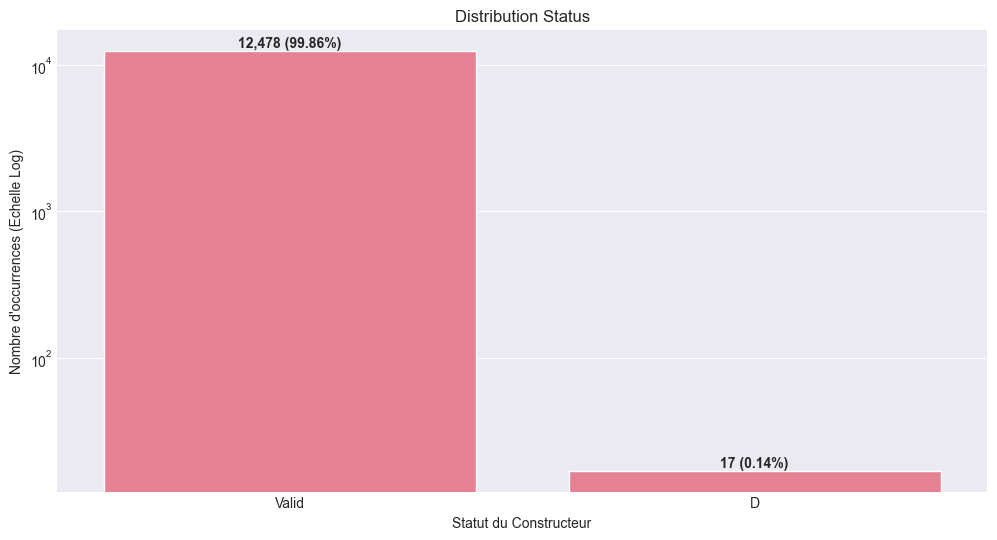

In [422]:
# Inspection des chiffres bruts
print("Distribution de la colonne 'status' :")
print(constructor_results['status'].value_counts(dropna=False))
print("\nPourcentage :")
print(constructor_results['status'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str) + '%')

# Visualisation
plt.figure(figsize=(12, 6))

# Remplissage temporaire des NaN pour visualisation, permet de voir la catégorie "Valid" explicitement sur le graphe
sns.countplot(
    x=constructor_results['status'].fillna('Valid'),
    order=['Valid', 'D'] # On force l'ordre pour la lisibilité
)

plt.title("Distribution Status")
plt.yscale('log') # Echelle log pour visualiser les valeurs minoritaires
plt.ylabel("Nombre d'occurrences (Echelle Log)")
plt.xlabel("Statut du Constructeur")

# Ajout annotations
plt.text(0, 12478, '12,478 (99.86%)', ha='center', va='bottom', fontweight='bold')
plt.text(1, 17, '17 (0.14%)', ha='center', va='bottom', fontweight='bold')

plt.show()

Après cette première étude, nous observons comme attendu un fort déséquilbre entre les nuls (appelés Valid) et les constructeurs contenant un statut "D". 

Ce déséquilibre pourrait être intéressant si nous cherchions à déterminer les écuries championnes d'une saison de F1, seulement ici nous nous concentrons uniquement sur une course. Ainsi, il nous est inutile de savoir quelle voiture a été disqualifiée pour triche (comme McLaren en 2007 avec le scandale Spygate) puisque cela ne révèle en rien ses performances techniques sur le terrain.

Ainsi, nous pouvons donc supprimer cette colonne de notre dataset.

In [423]:
constructor_results.drop(columns=['status'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [424]:
print("Constructor_results :\n",constructor_results.head())

Constructor_results :
    constructorResultsId  raceId  constructorId  points
0                     1      18              1    14.0
1                     2      18              2     8.0
2                     3      18              3     9.0
3                     4      18              4     5.0
4                     5      18              5     2.0


### Nettoyage de constructor_standings 

Pour ce dataset, nous avons décidé de supprimer la colonne positionText. En effet, celle-ci n'est qu'une duplication au format texte de la variable numérique position et n'apporte aucune information supplémentaire exploitable. Sa suppression élimine une redondance inutile et prévient l'introduction de bruit (valeurs non numériques) qui pourrait perturber l'apprentissage de notre modèle.

In [425]:
constructor_standings.drop(columns=['positionText'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [426]:
print("Constructor_standings :\n",constructor_standings.head())

Constructor_standings :
    constructorStandingsId  raceId  constructorId  points  position  wins
0                       1      18              1    14.0         1     1
1                       2      18              2     8.0         3     0
2                       3      18              3     9.0         2     0
3                       4      18              4     5.0         4     0
4                       5      18              5     2.0         5     0


### Nettoyage Driver_standings :

Même cas que pour Constructor standings avec la colonne positionText.

In [427]:
driver_standings.drop(columns=['positionText'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [428]:
print("Driver_standings :\n",driver_standings.head())

Driver_standings :
    driverStandingsId  raceId  driverId  points  position  wins
0                  1      18         1    10.0         1     1
1                  2      18         2     8.0         2     0
2                  3      18         3     6.0         3     0
3                  4      18         4     5.0         4     0
4                  5      18         5     4.0         5     0


### Analyse de la distribution des nationalités des constructeurs

Cette analyse univariée a pour but d'identifier de potentiels biais géographiques historiques dans l'ingénierie automobile pour voir si l'origine d'une écurie influence sa probabilité de succès.

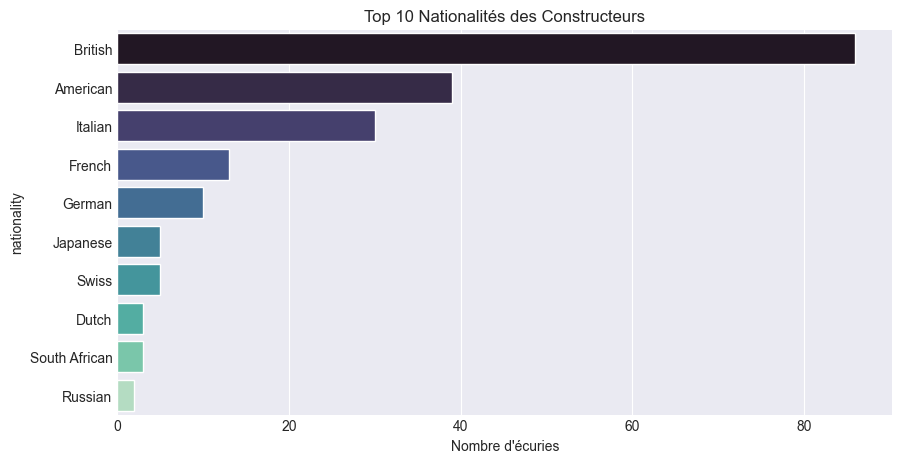

In [429]:
plt.figure(figsize=(10, 5))
nat_counts = constructors['nationality'].value_counts().head(10)

sns.barplot(
    x=nat_counts.values, 
    y=nat_counts.index, 
    hue=nat_counts.index, 
    legend=False, 
    palette='mako'
)

plt.title("Top 10 Nationalités des Constructeurs")
plt.xlabel("Nombre d'écuries")
plt.show()

Après visualisation des résultats, le graphique révèle une hégémonie du Royaume-Uni, loin devant l'Italie et les Etats-Unis. La variable nationality est donc discriminante, mais sa haute cardinalité exigera peut-être de regrouper les "petites nations" pour éviter le bruit.

### Analyse de la distribution des nationalités des pilotes

Dans l'analyse du dataset circuit, nous avions dit qu'il serait intéressant d'analyser la corrélation possibles des victoires à domicile afin d'en conclure d'un potentiel avantage à mettre en avant pour notre modèle. L'analyse de la distribution des nationalités des pilotes pourrait également révèler de potentiels biais historiques (domination de certains pays).

Contrairement à la nationalité des constructeurs qui traduit une domination technologique et industrielle, celle des pilotes met en lumière les viviers de talents historiques. Cette distinction est cruciale pour identifier les biais structurels du dataset, notamment la sur-représentation de nations comme le Royaume-Uni ou l'Allemagne. De plus, isoler cette variable est indispensable pour le feature engineering futur, afin de tester l'hypothèse du "Home Advantage" en croisant la nationalité du pilote avec celle du circuit.

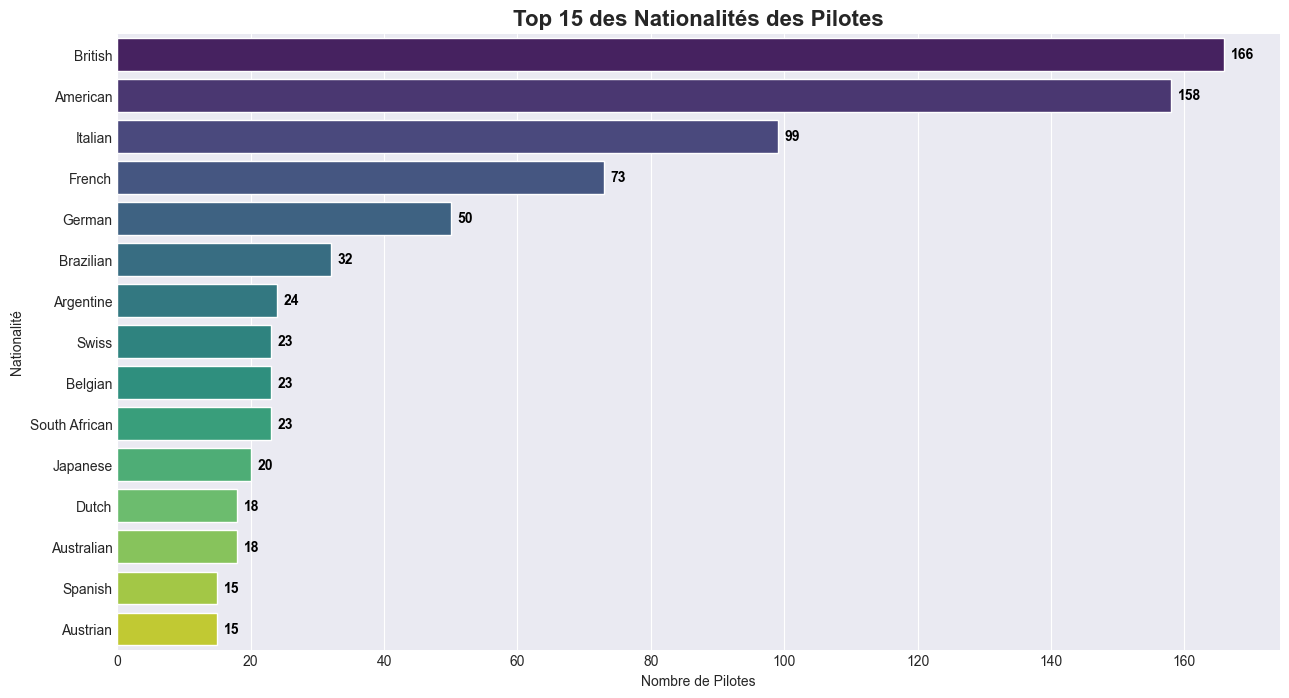

In [430]:
# Calcul des fréquences sur la colonne brute
nationality_counts = drivers['nationality'].value_counts()
top_nationalities = nationality_counts.head(15) # Top 15 pour la lisibilité

# Visualisation
plt.figure(figsize=(15, 8))

sns.barplot(
    x=top_nationalities.values,
    y=top_nationalities.index,
    hue=top_nationalities.index,
    legend=False,
    palette='viridis'
)

plt.title('Top 15 des Nationalités des Pilotes', fontsize=16, fontweight='bold')
plt.xlabel('Nombre de Pilotes')
plt.ylabel('Nationalité')

# Ajout des valeurs au bout des barres
for i, v in enumerate(top_nationalities.values):
    plt.text(v + 1, i, str(v), color='black', va='center', fontweight='bold')

plt.show()

Avec ce graphique, on déduit une certaine hégémonie de quelques nations historiques (comme le Royaume-Uni, les États-Unis ou encore l'Italie) face à une longue liste de pays jugés anecdotiques.

Ce fort déséquilibre signifie que la variable nationality contient beaucoup de bruit (haute cardinalité avec peu de fréquence) et devra probablement être simplifiée (par exemple en regroupant les "petites" nations) pour être utile à notre modèle prédictif.

### Nettoyage du fichier drivers

Pour ce dataset, nous avons identifié plusieurs colonnes qui n'ont pas vraiment d'utilité dans la prédiction de la victoire ou non d'une écurie sur un circuit.

##### Distribution en pourcentage de la colonne nombre

In [431]:
print(drivers['number'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str) + '%')

number
NaN     93.36%
6.0      0.23%
88.0     0.23%
10.0     0.23%
40.0     0.23%
22.0     0.23%
99.0     0.23%
28.0     0.23%
9.0      0.23%
21.0     0.23%
2.0      0.23%
4.0      0.23%
19.0     0.12%
14.0     0.12%
7.0      0.12%
13.0     0.12%
27.0     0.12%
5.0      0.12%
8.0      0.12%
44.0     0.12%
25.0     0.12%
3.0      0.12%
77.0     0.12%
20.0     0.12%
17.0     0.12%
45.0     0.12%
26.0     0.12%
33.0     0.12%
12.0     0.12%
55.0     0.12%
11.0     0.12%
98.0     0.12%
53.0     0.12%
30.0     0.12%
94.0     0.12%
31.0     0.12%
18.0     0.12%
16.0     0.12%
35.0     0.12%
63.0     0.12%
23.0     0.12%
51.0     0.12%
89.0     0.12%
47.0     0.12%
24.0     0.12%
81.0     0.12%
38.0     0.12%
Name: proportion, dtype: object


La colonne nombre contient 802 valeurs nulles sur 859 (93.36% de vide). Il nous faut donc, si nous la conservons, penser à la nettoyer.
Historiquement, les numéros des pilotes de F1 changeaient chaque année ou n'existaient pas. Aujourd'hui, ils ne sont là que pour le marketing (le numéro 44 est par exemple celui d'Hamilton). Il n'existe donc aucune corrélation physique entre le numéro du pilote et sa vitesse et cela apporte même une redondance si on l'utilise pour son identification. Nous pouvons donc la supprimer.

In [432]:
drivers.drop(columns=['number'], inplace=True, errors='ignore')

#### Distribution en pourcentage de la colonne code

In [433]:
print(drivers['code'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str) + '%')

code
NaN    88.13%
MSC     0.23%
VER     0.23%
MAG     0.23%
HAR     0.23%
        ...  
DEV     0.12%
PIA     0.12%
SAR     0.12%
LAW     0.12%
BEA     0.12%
Name: proportion, Length: 97, dtype: object


La colonne code, comme pour la colonne nombre contient une majorité de valeurs nulles (88.13%).
Cette variable est elle aussi plutôt inutile puisqu'elle n'est que l'abréviation du nom de famille du pilote. Nous pouvons donc la supprimer.

In [434]:
drivers.drop(columns=['code'], inplace=True, errors='ignore')

#### Suppression de driverRef

Cette colonne est une simple répétition des noms de famille, cela est inutile pour notre modèle qui utilisera les driverId pour identifier ces derniers. Nous pouvons donc l'éliminer.

In [435]:
drivers.drop(columns=['driverRef'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [436]:
print("Drivers :\n",drivers.head())

Drivers :
    driverId  forename     surname         dob nationality
0         1     Lewis    Hamilton  1985-01-07     British
1         2      Nick    Heidfeld  1977-05-10      German
2         3      Nico     Rosberg  1985-06-27      German
3         4  Fernando      Alonso  1981-07-29     Spanish
4         5    Heikki  Kovalainen  1981-10-19     Finnish


### Nettoyage de Lap_Times

Pour ce dataset, la seule colonne à retirer est celle appelée time. Celle-ci contient le temps mis par le pilote pour faire un tour de piste. Cependant elle est redondante puisqu'elle est déjà contenue dans la colonnes milliseconds. De plus, le type des données étant un string cela est illisible pour notre modèle.

In [437]:
lap_times.drop(columns=['time'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [438]:
print("Lap_times :\n",lap_times.head())

Lap_times :
    raceId  driverId  lap  position  milliseconds
0     841        20    1         1         98109
1     841        20    2         1         93006
2     841        20    3         1         92713
3     841        20    4         1         92803
4     841        20    5         1         92342


### Analyse distribution des pit_stops et nettoyage du dataframe

L'analyse de la distribution des arrêts aux stands est importante dans notre cas puisqu'elle nous permet d'établir la norme de performance. Elle est utile pour pouvoir définir mathématiquement ce qu'est un arrêt "standard" (le temps incompressible dans la voie des stands + changement de pneus) par rapport à un arrêt "raté" (problème d'écrou, changement d'aileron, pénalité). Cette distinction est cruciale pour le feature engineering, car elle permet de créer un indicateur de fiabilité opérationnelle des écuries en pénalisant les écarts à cette norme, plutôt que d'utiliser une simple moyenne qui serait faussée par les événements rares.

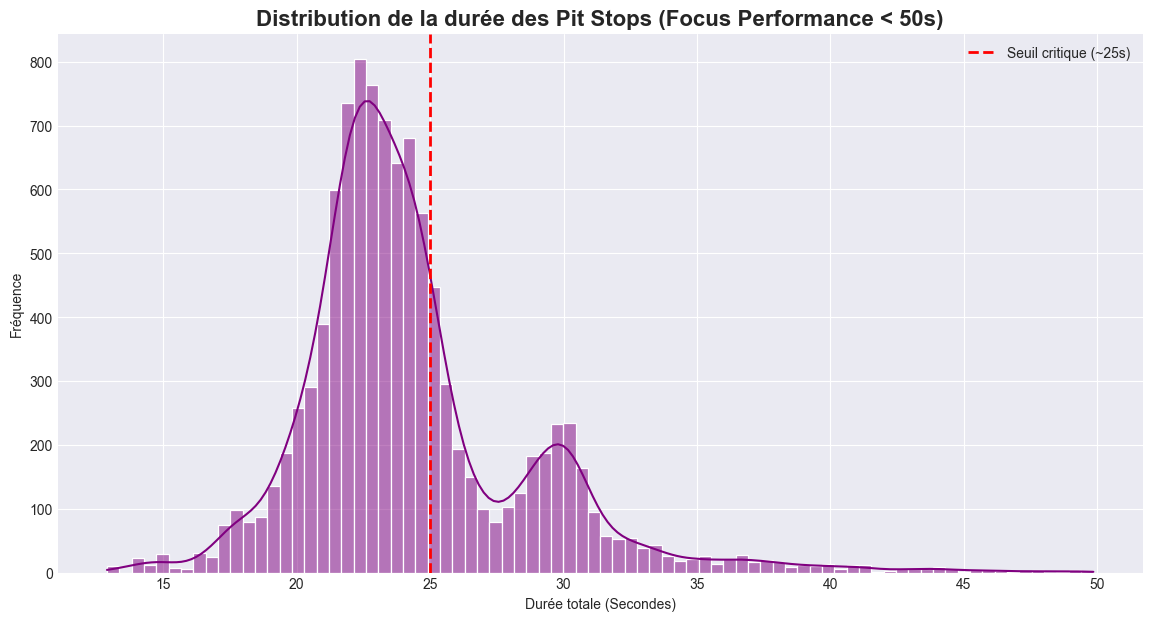

--- Statistiques des Pit Stops (en secondes) ---
count    10945.000000
mean        85.532631
std        312.108764
min         12.897000
25%         21.941000
50%         23.601000
75%         26.399000
max       3069.017000
Name: seconds, dtype: float64

Nombre d'arrêts 'Hors Norme' (>50s) exclus du graphe : 533


In [439]:
# Feature Engineering (Temporaire pour la visualisation)
# Conversion en secondes pour une meilleure analyse et lisibilité
pit_stops['seconds'] = pit_stops['milliseconds'] / 1000

# Visualisation : Distribution des temps d'arrêt
plt.figure(figsize=(14, 7))

# FILTRE STRATÉGIQUE : On ne regarde que les arrêts < 50 secondes.
# Pourquoi ? Parce que les arrêts de 3 minutes (réparations, pluie) écrasent l'échelle et nous empêchent de juger la performance standard des mécaniciens.
subset_pits = pit_stops[pit_stops['seconds'] < 50]

sns.histplot(subset_pits['seconds'], bins=80, kde=True, color='purple')

plt.title('Distribution de la durée des Pit Stops (Focus Performance < 50s)', fontsize=16, fontweight='bold')
plt.xlabel('Durée totale (Secondes)')
plt.ylabel('Fréquence')

# Ajout d'un seuil critique visuel (ex: 25s = arrêt lent/raté)
plt.axvline(x=25, color='red', linestyle='--', linewidth=2, label='Seuil critique (~25s)')
plt.legend()

plt.show()

# Statistiques pour confirmer
print("--- Statistiques des Pit Stops (en secondes) ---")
print(pit_stops['seconds'].describe())
print(f"\nNombre d'arrêts 'Hors Norme' (>50s) exclus du graphe : {len(pit_stops[pit_stops['seconds'] >= 50])}")

L'histogramme met en évidence une distribution gaussienne très nette centrée autour de 23-24 secondes, définissant ainsi la norme de performance opérationnelle pour un arrêt réussi. La chute brutale des fréquences au-delà de 28 secondes permet de tracer une frontière claire entre une simple lenteur et un incident technique ou stratégique majeur. Contrairement à la médiane stable, la moyenne est fortement biaisée par une "longue traîne" d'arrêts anormaux supérieurs à 50 secondes, correspondant à des réparations ou des pénalités. Cette distinction impose de traiter ces valeurs extrêmes comme des anomalies (outliers) dans le modèle, plutôt que de les laisser fausser l'évaluation de l'efficacité des équipes. En somme, la régularité sous le seuil critique des 26 secondes est le véritable indicateur de compétence, tandis que tout dépassement signale une rupture de la normalité.

Pour le nettoyage, ici on retire time et duration pour les mêmes raisons que pour le jeu de données lap_times précèdemment optimisé.

In [440]:
pit_stops.drop(columns=['time'], inplace=True, errors='ignore')
pit_stops.drop(columns=['duration'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [441]:
print("Pit_stops :\n",pit_stops.head())

Pit_stops :
    raceId  driverId  stop  lap  milliseconds  seconds
0     841       153     1    1         26898   26.898
1     841        30     1    1         25021   25.021
2     841        17     1   11         23426   23.426
3     841         4     1   12         23251   23.251
4     841        13     1   13         23842   23.842


### Nettoyage de Qualifying

Drop : qualifyId (Index inutile), number (Redondant avec drivers), q1, q2, q3.

Pourquoi ? Les temps Q1-Q3 sont au format texte ("1:24.333"). Sans feature engineering immédiat (conversion en ms), c'est inexploitable. La colonne position résume déjà toute la séance.

In [442]:
print("Qualifying :\n",qualifying.head())

Qualifying :
    qualifyId  raceId  driverId  constructorId  number  position        q1  \
0          1      18         1              1      22         1  1:26.572   
1          2      18         9              2       4         2  1:26.103   
2          3      18         5              1      23         3  1:25.664   
3          4      18        13              6       2         4  1:25.994   
4          5      18         2              2       3         5  1:25.960   

         q2        q3  
0  1:25.187  1:26.714  
1  1:25.315  1:26.869  
2  1:25.452  1:27.079  
3  1:25.691  1:27.178  
4  1:25.518  1:27.236  


L'Id unique qualifyId du dataset est parfaitement inutile dans notre étude puisque il ne nous apporte aucune information et n'est la clé secondaire d'aucun autre dataset. Ainsi on peut donc supprimer cette feature.

In [443]:
qualifying.drop(columns=['qualifyId'], inplace=True, errors='ignore')

Tout comme pour drivers, la feature number ne sert à rien, surtout que le driverId est déjà renseigné. Cette colonne représente donc une information redondante qui pourrait perdre notre modèle. Nous avons donc décidé de supprimer également cette colonne.

In [444]:
qualifying.drop(columns=['number'], inplace=True, errors='ignore')

Enfin, les temps de qualifications recensés dans q1, q2 et q3 sont actuellement inutilisables pour notre modèle puisque ce sont des temps renseignés sous la forme de string. De plus, ce qui nous intéresse est le pilote (ou constructeur) ayant fait un temps minimal au total sur les 3 tours. Cette information étant déjà transmise par la colonne position, on peut donc supprimer ces données inutiles.

In [445]:
qualifying.drop(columns=['q1'], inplace=True, errors='ignore')
qualifying.drop(columns=['q2'], inplace=True, errors='ignore')
qualifying.drop(columns=['q3'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [446]:
print("Qualifying :\n",qualifying.head())

Qualifying :
    raceId  driverId  constructorId  position
0      18         1              1         1
1      18         9              2         2
2      18         5              1         3
3      18        13              6         4
4      18         2              2         5


### Analyse du nombre de courses par saison et nettoyage du dataset races

Notre but, dans cette étude est de comprendre la distribution temporelle des données pour savoir si le modèle sera entraîné majoritairement sur de la F1 moderne ou ancienne.

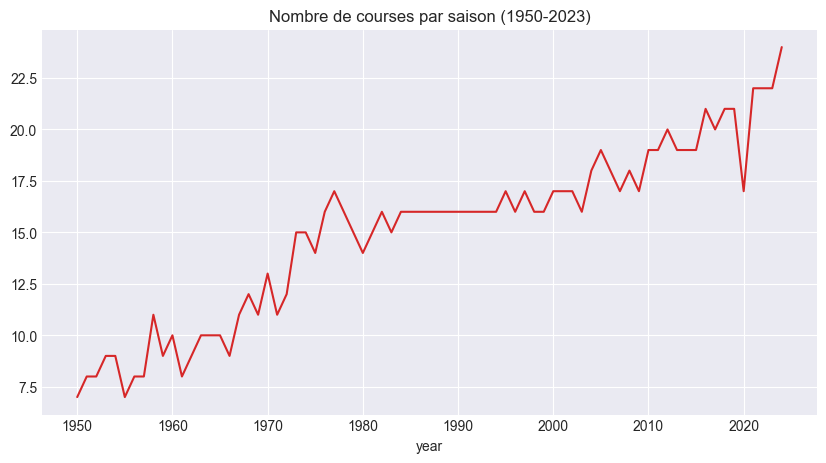

In [447]:
plt.figure(figsize=(10, 5))
races_year = races['year'].value_counts().sort_index()
sns.lineplot(x=races_year.index, y=races_year.values, color='tab:red')
plt.title("Nombre de courses par saison (1950-2023)")
plt.show()

On observe une densification nette du calendrier (passage de 7 à 24 courses). Cette augmentation crée un biais de récence favorable, ainse le modèle aura plus d'exemples sur la F1 moderne, ce qui est idéal pour nous qui souhaitons prédire les courses actuelles.

Pour le nettoyage, on peut supprimer les features fp1_date, fp2_date, fp3_date, quali_date, sprint_date. Celles-ci, en plus d'être vides, représentent les dates des séances d'essais libreset n'ont aucun pouvoir prédictif sur le résultat final.

In [448]:
races.drop(columns=['fp1_date'], inplace=True, errors='ignore')
races.drop(columns=['fp2_date'], inplace=True, errors='ignore')
races.drop(columns=['fp3_date'], inplace=True, errors='ignore')
races.drop(columns=['quali_date'], inplace=True, errors='ignore')
races.drop(columns=['sprint_date'], inplace=True, errors='ignore')

On peut également supprimer les colonnes fp1_time, fp2_time, fp3_time, quali_time, sprint_time. Celles-ci sont également vides pour la plupart et n'indiquent qu'un horaire. Inutile donc dans notre cas. On peut également retirer la variable time qui ne sert qu'à indiquer l'heure de départ.

In [449]:
races.drop(columns=['fp1_time'], inplace=True, errors='ignore')
races.drop(columns=['fp2_time'], inplace=True, errors='ignore')
races.drop(columns=['fp3_time'], inplace=True, errors='ignore')
races.drop(columns=['quali_time'], inplace=True, errors='ignore')
races.drop(columns=['sprint_time'], inplace=True, errors='ignore')
races.drop(columns=['time'], inplace=True, errors='ignore')

Nouveau dataset nettoyé

In [450]:
print("Races :\n",races.head())

Races :
    raceId  year  round  circuitId                   name        date
0       1  2009      1          1  Australian Grand Prix  2009-03-29
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05
2       3  2009      3         17     Chinese Grand Prix  2009-04-19
3       4  2009      4          3     Bahrain Grand Prix  2009-04-26
4       5  2009      5          4     Spanish Grand Prix  2009-05-10


### Analyse de distribution des positions de départ des pilotes victorieux

C'est évidemment le paramètre que l'on attend être le plus important. En effet, il paraît plutôt logique qu'une voiture partant en première position soit plus susceptible de remporter la course.

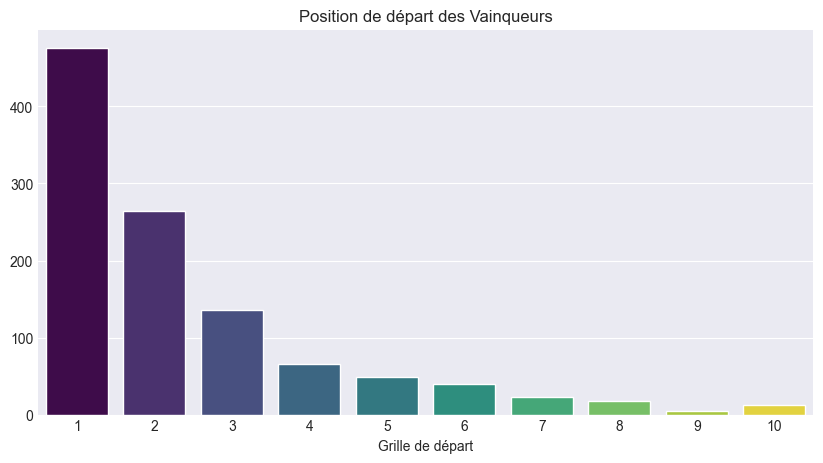

In [451]:
plt.figure(figsize=(10, 5))
winners = results[results['positionOrder'] == 1]
win_grid = winners['grid'].value_counts().sort_index().head(10)

sns.barplot(
    x=win_grid.index, 
    y=win_grid.values, 
    hue=win_grid.index,  
    legend=False,        
    palette='viridis'
)

plt.title("Position de départ des Vainqueurs")
plt.xlabel("Grille de départ")
plt.show()

La corrélation est en effet brutale : la majorité des vainqueurs partent de la Pole Position et les chances de gagner s'effondrent après la 3ème place. Cela confirme que la variable grid sera le prédicteur le plus puissant de notre modèle.

Après cette rapide analyse sur la corrélation possible entre position de départ et vainqueurs, place au nettoyage. Comme pour races et drivers, on peut supprimer la colonne number puirsqu'elle n'apporte rien.

In [452]:
results.drop(columns=['number'], inplace=True, errors='ignore')

PositionText est elle aussi inutile puisque ce n'est qu'une copie de positionOrder au format string, inutilisable pour notre modèle donc.

In [453]:
results.drop(columns=['positionText'], inplace=True, errors='ignore')

Ici, il nous est impératif de supprimer certaines colonnes puisqu'elles comportent un haut risque de Data Leakage. En effet, les colonnes comme fastestLap, rank, milliseconds, ou encore position comportent toutes des données provenant du futur que l'on ne connaît qu'après la course. Les inclure reviendrait donc à donner la réponse au modèle avant qu'il ne fasse sa prédiction.

In [454]:
results.drop(columns=['fastestLap'], inplace=True, errors='ignore')
results.drop(columns=['rank'], inplace=True, errors='ignore')
results.drop(columns=['milliseconds'], inplace=True, errors='ignore')
results.drop(columns=['position'], inplace=True, errors='ignore')
results.drop(columns=['fastestLapTime'], inplace=True, errors='ignore')
results.drop(columns=['fastestLapSpeed'], inplace=True, errors='ignore')
results.drop(columns=['laps'], inplace=True, errors='ignore')
results.drop(columns=['time'], inplace=True, errors='ignore')


Nouveau dataset nettoyé

In [455]:
print("Results :\n",results.head())

Results :
    resultId  raceId  driverId  constructorId  grid  positionOrder  points  \
0         1      18         1              1     1              1    10.0   
1         2      18         2              2     5              2     8.0   
2         3      18         3              3     7              3     6.0   
3         4      18         4              4    11              4     5.0   
4         5      18         5              1     3              5     4.0   

   statusId  
0         1  
1         1  
2         1  
3         1  
4         1  


### Fiabilité : Analyse des Abandons (Status)

Les abandons ("Engine", "Gearbox") sont fréquents, surtout dans les années passées. Il pourrait être importants dans la prédiction d'un vainqueur (accidents causés par le conducteur, problèmes liés au véhicules) ou non (accidents liés à un autre usager). Certains circuits sont même considérés comme des "tueurs de voitures"

<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:7: SyntaxWarning: invalid escape sequence '\+'
C:\Users\mathi\AppData\Local\Temp\ipykernel_20076\3755649722.py:7: SyntaxWarning: invalid escape sequence '\+'
  dnf_data = df_status[~df_status['status'].str.contains('Finished|\+', regex=True)]


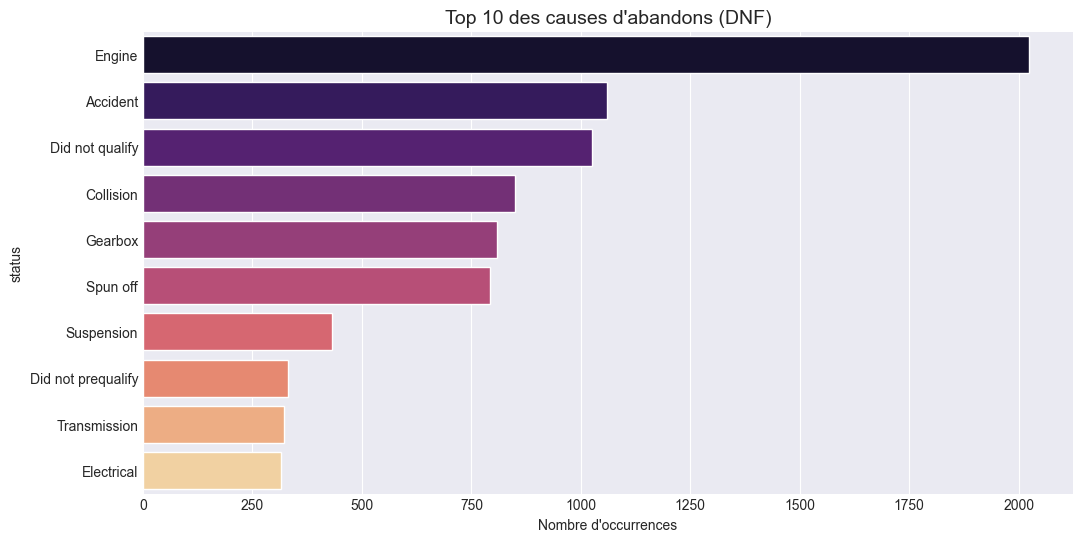

In [456]:
def analyze_reliability():
    
    # Fusion avec la table status (Assure-toi que results_df et status_df sont bien chargés avant)
    df_status = results_df.merge(status_df, on='statusId')
    
    # Filtrer ce qui n'est pas "Finished" ou "+1 Lap" (les abandons réels)
    dnf_data = df_status[~df_status['status'].str.contains('Finished|\+', regex=True)]
    
    top_causes = dnf_data['status'].value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    
    sns.barplot(
        y=top_causes.index, 
        x=top_causes.values, 
        hue=top_causes.index,  # On lie la couleur à la catégorie (Y)
        legend=False,          
        orient='h', 
        palette='magma'
    )
    
    plt.title("Top 10 des causes d'abandons (DNF)", fontsize=14)
    plt.xlabel("Nombre d'occurrences")
    plt.show()

analyze_reliability()

L'histogramme révèle une hiérarchie claire des défaillances en F1 : les problèmes mécaniques (Moteur en tête avec plus de 2000 cas) restent historiquement la cause majeure d'abandon, doublant presque la seconde cause.

Cependant, la violence de la course est omniprésente, le cumul des incidents de pilotage (Accident, Collision, Spun off) représentant un volume d'abandons supérieur à celui des moteurs seuls, soulignant que la fiabilité technique ne suffit pas pour finir une course.

Ainsi, il pourrait être intéressant de créer une feature constructor_reliability : afin d'analyser le taux de courses terminées par l'écurie sur la saison en cours.

### Datasets inutilisables pour notre modèle de prédiction

Enfin, avant de passer au merged, nous avons encore besoin de nettoyer quelques jeux de données qui sont complètement inutilisables pour notre étude. C'est le cas de seasons.csv qui est un fichier purement redondant puisqu'il n'indique que l'année est déjà donnée dans races.csv. Le dataset sprint_results.csv est également inutilisable car l'épreuve des sprints n'existe que depuis 2021. Il y a donc un fort risque de déstabilisation de notre modèle pour rien. L'impact réel des sprints (points et grille) est de toute façon déjà capturé dans nos fichiers principaux (results et qualifying). 

Ainsi, la suppression de ces 2 fichiers élimine du bruit massif sans perdre une seule information prédictive.

In [457]:
try:
    del seasons
    del sprint_results
    print("Succès : Les fichiers 'seasons' et 'sprint_results' ont été supprimés.")
except NameError:
    print("Info : Ces fichiers étaient déjà supprimés ou non chargés.")

Succès : Les fichiers 'seasons' et 'sprint_results' ont été supprimés.


### Nouvel audit de qualité de nos données

In [458]:
audit_data_quality({
    'circuits': circuits,
    'constructor_results': constructor_results,
    'constructor_standings': constructor_standings,
    'constructors': constructors,
    'driver_standings': driver_standings,
    'drivers': drivers,
    'lap_times': lap_times,
    'pit_stops': pit_stops,
    'qualifying': qualifying,
    'races': races,
    'results': results,
    'status': status
})

--- Rapport de Qualité des Données ---

Jeu de données : CIRCUITS
Dimensions : (77, 4)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTOR_RESULTS
Dimensions : (12495, 4)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTOR_STANDINGS
Dimensions : (13261, 6)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTORS
Dimensions : (212, 4)
Aucune valeur manquante détectée.

Jeu de données : DRIVER_STANDINGS
Dimensions : (34574, 6)
Aucune valeur manquante détectée.

Jeu de données : DRIVERS
Dimensions : (859, 5)
Aucune valeur manquante détectée.

Jeu de données : LAP_TIMES
Dimensions : (575029, 5)
Aucune valeur manquante détectée.

Jeu de données : PIT_STOPS
Dimensions : (10945, 6)
Aucune valeur manquante détectée.

Jeu de données : QUALIFYING
Dimensions : (10234, 4)
Aucune valeur manquante détectée.

Jeu de données : RACES
Dimensions : (1125, 6)
Aucune valeur manquante détectée.

Jeu de données : RESULTS
Dimensions : (26499, 8)
Aucune valeur manquante détectée

On ne détecte désormais plus aucune valeurs manquantes dans les datasets ce qui nous arrange puisque cela signifie que nous n'aurons pas besoin de recourir à des techniques d'imputation.

# Mapping de constructeurs

Avant de commencer le merged de notre dataset ainsi qu'une étude plus approfondie, il est important de passer par une étape de mapping de nos constructeurs. En effet, nous souhaitons prédire les résultats dans un contexte récent. Ainsi une écurie ayant concourru par le passé a pu être racheté par une écurie participant actuellement aux courses. Ainsi nous devons attribuer les victoires de cette ancienne écurie à la nouvelle.

Pour les écuries plus anciennes qui n'existent plus et n'auraient pas été rachetées ou fusionnées, nous avons décidé de les garder afin que les études des anciennes courses menées par notre modèle soient plus justes.

In [459]:
constructor_mapping = {
    # Mercedes (Brackley) : Tyrrell -> BAR -> Honda -> Brawn -> Mercedes
    15: 131, 16: 131, 17: 131, 23: 131,
    # Red Bull (Milton Keynes) : Stewart -> Jaguar -> Red Bull
    19: 9, 18: 9,
    # Alpine (Enstone) : Benetton -> Renault -> Lotus -> Alpine
    22: 214, 4: 214, 208: 214,
    # Aston Martin (Silverstone) : Jordan -> Midland -> Spyker -> Force India -> Racing Point -> Aston
    20: 117, 21: 117, 24: 117, 10: 117, 211: 117,
    # RB (Faenza) : Minardi -> Toro Rosso -> AlphaTauri -> RB
    14: 213, 5: 213,
    # Sauber (Hinwil) : Sauber -> BMW Sauber -> Sauber -> Alfa Romeo -> Sauber
    51: 15 # Alfa Romeo -> Sauber (Validé)
}

print("Application du mapping constructeurs...")
results['constructorId'] = results['constructorId'].replace(constructor_mapping)
qualifying['constructorId'] = qualifying['constructorId'].replace(constructor_mapping)


Application du mapping constructeurs...


In [460]:
# Définition du Mapping (Pour identifier qui supprimer)
def get_id(name):
    res = constructors[constructors['name'] == name]['constructorId'].values
    return res[0] if len(res) > 0 else None

# Cibles (Les survivants)
merc_id = get_id('Mercedes')
rb_id = get_id('Red Bull')
alpine_id = get_id('Alpine F1 Team')
aston_id = get_id('Aston Martin')
sauber_id = get_id('Sauber')
rb_visa_id = get_id('RB F1 Team')

# Dictionnaire des ancêtres (Ceux qui doivent disparaître)
mapping = {}
# Lignée Mercedes
mapping.update({get_id('Tyrrell'): merc_id, get_id('BAR'): merc_id, get_id('Honda'): merc_id, get_id('Brawn'): merc_id})
# Lignée Red Bull
mapping.update({get_id('Stewart'): rb_id, get_id('Jaguar'): rb_id})
# Lignée Alpine
mapping.update({get_id('Benetton'): alpine_id, get_id('Renault'): alpine_id, get_id('Lotus F1'): alpine_id})
# Lignée Aston Martin
mapping.update({get_id('Jordan'): aston_id, get_id('Midland'): aston_id, get_id('Spyker'): aston_id, get_id('Force India'): aston_id, get_id('Racing Point'): aston_id})
# Lignée Sauber
mapping.update({get_id('Alfa Romeo'): sauber_id, get_id('BMW Sauber'): sauber_id})
# Lignée RB (Minardi)
mapping.update({get_id('Minardi'): rb_visa_id, get_id('Toro Rosso'): rb_visa_id, get_id('AlphaTauri'): rb_visa_id})

# Nettoyage des None
ids_to_drop = [k for k in mapping.keys() if k is not None]

# Création du Nouveau Dataset Constructeur (Suppression des ancêtres)
mapping_constru = constructors[~constructors['constructorId'].isin(ids_to_drop)].copy()

print(f"Dataset 'constructors' réduit de {len(constructors)} à {len(mapping_constru)} lignes.")
print(f"Écuries supprimées : {len(ids_to_drop)}")
print(mapping_constru.head())

Dataset 'constructors' réduit de 212 à 194 lignes.
Écuries supprimées : 18
   constructorId constructorRef         name nationality
0              1        mclaren      McLaren     British
2              3       williams     Williams     British
5              6        ferrari      Ferrari     Italian
6              7         toyota       Toyota    Japanese
7              8    super_aguri  Super Aguri    Japanese


## Dernières étapes de nettoyage et de Feature Engineering avant Merged

Cette étape est cruciale puisqu'elle évite à nos données brutes, en fusionner de provoquer une explosion de dimensionnalité et des doublons (problème de cardinalité "un-vers-plusieurs", notamment avec les arrêts aux stands). En nettoyant et en agrégeant les données satellites (Pit Stops, Qualifs) en amont, nous garantissons que chaque table est réduite à sa forme la plus pure et alignée sur la granularité cible (une ligne par pilote par course). De plus, calculer des indicateurs temporels complexes comme la "Fiabilité Historique" est beaucoup plus sûr sur des tables dédiées avant la fusion, car cela évite les erreurs de tri et le "Data Leakage" (fuite d'informations futures) qui pourraient survenir dans un dataset massif et désordonné.

Nous convertissons d'abord les dates brutes en objets temporels (datetime), étape indispensable pour trier chronologiquement les événements et calculer ultérieurement l'âge exact des pilotes. Parallèlement nous allégeons et retirons certaines données susceptibles de polluer notre dataframe.

In [461]:
races['date'] = pd.to_datetime(races['date'])
races = races[['raceId', 'year', 'round', 'circuitId', 'name', 'date']]
print(races.head())

   raceId  year  round  circuitId                   name       date
0       1  2009      1          1  Australian Grand Prix 2009-03-29
1       2  2009      2          2   Malaysian Grand Prix 2009-04-05
2       3  2009      3         17     Chinese Grand Prix 2009-04-19
3       4  2009      4          3     Bahrain Grand Prix 2009-04-26
4       5  2009      5          4     Spanish Grand Prix 2009-05-10


In [462]:
drivers['full_name'] = drivers['forename'] + ' ' + drivers['surname']
drivers['dob'] = pd.to_datetime(drivers['dob'])
drivers = drivers[['driverId', 'dob', 'nationality', 'full_name']]
print(drivers.head())

   driverId        dob nationality          full_name
0         1 1985-01-07     British     Lewis Hamilton
1         2 1977-05-10      German      Nick Heidfeld
2         3 1985-06-27      German       Nico Rosberg
3         4 1981-07-29     Spanish    Fernando Alonso
4         5 1981-10-19     Finnish  Heikki Kovalainen


La séance de qualification représente la vitesse intrinsèque de la voiture sur un tour, dégagée des contraintes de gestion de course. Nous isolons ici la position sur la grille, qui reste statistiquement le prédicteur le plus fort de la victoire finale. Nous renommons explicitement cette variable en grid_qualifying pour éviter toute confusion avec la grille finale ajustée des pénalités.

In [463]:
qualifying = qualifying[['raceId', 'driverId', 'constructorId', 'position']]
qualifying.rename(columns={'position': 'grid_qualifying'}, inplace=True) # Renommage pour clarté
print(qualifying.head())

   raceId  driverId  constructorId  grid_qualifying
0      18         1              1                1
1      18         9              2                2
2      18         5              1                3
3      18        13              6                4
4      18         2              2                5


Dans notre fichier pit_stops actuel les arrêts aux stands présente une structure "un-vers-plusieurs" (plusieurs arrêts pour une seule course). Cela est  incompatible avec une fusion directe qui dupliquerait les lignes de résultats. Nous procédons donc à une agrégation (Group By) pour résumer la stratégie de chaque pilote en deux indicateurs de performance  : le nombre total d'arrêts (pit_stops_count) et le temps total perdu dans la voie des stands (pit_stops_duration). Cela transforme une série d'événements discrets en une métrique de performance continue.

In [464]:
pit_stops_agg = pit_stops.groupby(['raceId', 'driverId']).agg(
    pit_stops_count=('stop', 'max'),
    pit_stops_duration=('milliseconds', 'sum')
).reset_index()
print(pit_stops_agg.head())

   raceId  driverId  pit_stops_count  pit_stops_duration
0     841         1                2               46426
1     841         2                2               48092
2     841         3                1               23716
3     841         4                3               72165
4     841         5                1               24865


Dans le codesuivant, nous transformons des informations descriptives (le statut d'abandon) en une variable prédictive. En identifiant les pannes mécaniques passées via les codes statusId, nous calculons un "taux de fiabilité" évolutif pour chaque constructeur. L'utilisation d'une moyenne glissante avec un décalage temporel (shift(1)) est impérative : elle garantit que la fiabilité estimée pour une course N est calculée uniquement sur les événements des courses 0 à N-1, empêchant ainsi le modèle de "lire l'avenir" en connaissant la panne avant le départ.

In [465]:
# On joint results avec status pour avoir la cause de l'abandon
full_status = results[['raceId', 'constructorId', 'statusId']].merge(status, on='statusId')

# On joint avec races pour avoir l'ordre chronologique
full_status = full_status.merge(races[['raceId', 'date']], on='raceId').sort_values('date')

# Définition des pannes mécaniques
mech_failures = ['Engine', 'Gearbox', 'Transmission', 'Clutch', 'Hydraulics', 'Electrical']
full_status['is_mechanical_failure'] = full_status['status'].str.contains('|'.join(mech_failures), case=False).astype(int)

# Calcul de la moyenne glissante (SHIFT(1) est vital pour ne pas lire le futur)
# Cela nous donne le % de fiabilité de l'écurie AVANT le départ de la course
reliability_score = full_status.groupby('constructorId')['is_mechanical_failure'] \
    .transform(lambda x: 1 - x.shift(1).expanding().mean())

# Intégration dans results
results['constructor_reliability'] = reliability_score.fillna(1.0) # 1.0 par défaut pour les nouveaux
print(results.head())

   resultId  raceId  driverId  constructorId  grid  positionOrder  points  \
0         1      18         1              1     1              1    10.0   
1         2      18         2              2     5              2     8.0   
2         3      18         3              3     7              3     6.0   
3         4      18         4            214    11              4     5.0   
4         5      18         5              1     3              5     4.0   

   statusId  constructor_reliability  
0         1                 0.847949  
1         1                 0.900000  
2         1                 0.861585  
3         1                 0.841996  
4         1                 0.848071  


## Merging sur results

La méthode utilisée est une jointure à gauche (LEFT JOIN), structurée autour de la table centrale results (chaque performance pilote/course). Le merging assemble l'événement (results) avec son contexte : la physique (circuits), l'humain (drivers), l'industrie (constructors) et la performance pré-course (qualifying). Stratégiquement, nous avons choisi de ne pas inclure tous les fichiers (tels que lap_times ou standings) pour des raisons de sécurité et de performance. Ces fichiers restants contiennent soit des millions de lignes inutiles qui alourdiraient le modèle, soit des informations post-course qui créeraient du Data Leakage (fuite de données futures) et rendraient la prédiction triviale. La table fusionnée finale contient ainsi uniquement les variables connues avant le départ, optimisant la richesse du signal tout en garantissant l'intégrité statistique.

In [466]:
constructors_to_merge = mapping_constru

df = results.merge(races, on='raceId', how='left')
df = df.merge(drivers, on='driverId', how='left')
df = df.merge(constructors_to_merge, on='constructorId', how='left', suffixes=('_driver', '_team'))
df = df.merge(circuits, on='circuitId', how='left')

df = df.merge(qualifying, on=['raceId', 'driverId', 'constructorId'], how='left')

df = df.merge(pit_stops_agg, on=['raceId', 'driverId'], how='left')

print(df.head())

   resultId  raceId  driverId  constructorId  grid  positionOrder  points  \
0         1      18         1              1     1              1    10.0   
1         2      18         2              2     5              2     8.0   
2         3      18         3              3     7              3     6.0   
3         4      18         4            214    11              4     5.0   
4         5      18         5              1     3              5     4.0   

   statusId  constructor_reliability  year  ...          full_name  \
0         1                 0.847949  2008  ...     Lewis Hamilton   
1         1                 0.900000  2008  ...      Nick Heidfeld   
2         1                 0.861585  2008  ...       Nico Rosberg   
3         1                 0.841996  2008  ...    Fernando Alonso   
4         1                 0.848071  2008  ...  Heikki Kovalainen   

   constructorRef       name_team nationality_team  \
0         mclaren         McLaren          British   
1       

## Tri Temporel

Le tri temporel est une opération de sécurité essentielle pour tout modèle prédictif basé sur des séries historiques comme la Formule 1. Il ordonne rigoureusement les données d'abord par l'année, puis par la manche de la saison (round), ce qui assure que nous respectons la chronologie des événements sans jamais permettre au modèle d'utiliser le résultat d'une course N pour prédire le résultat d'une course N-1. Ce tri est vital, car il garantit que lorsque nous séparerons les variables en X (features) et y (cible) juste après, l'alignement sera parfait. Sans cet ordre strict, l'extraction de la cible serait incohérente avec les features, ce qui mènerait à un Data Leakage et fausserait totalement l'apprentissage du modèle.

In [467]:
# --- 6. TRI TEMPOREL (Vital pour le ML) ---
# On trie par Année, puis par Manche, puis par Grille de départ
df.sort_values(by=['year', 'round', 'grid'], inplace=True)

# Remplissage des NaN logiques post-merge
# (Ex: Pas de qualif dans les années 50 -> On suppose qu'ils partent à leur place de grille)
if 'grid_qualifying' in df.columns:
    df['grid_qualifying'] = df['grid_qualifying'].fillna(df['grid'])
    
df['pit_stops_count'] = df['pit_stops_count'].fillna(0)
df['pit_stops_duration'] = df['pit_stops_duration'].fillna(0)

In [468]:
# Calcul de l'âge du pilote (en années) au moment de la course
# 'date' et 'dob' doivent être en format datetime, ce que tu as fait correctement plus tôt (Cellules 693-694)
df['driver_age'] = (df['date'] - df['dob']).dt.days / 365.25

# Suppression des colonnes de date brutes pour éviter le Data Leakage 
# (elles ne servent plus à rien et peuvent causer des problèmes dans le modèle)
df.drop(columns=['dob', 'date'], inplace=True, errors='ignore')

## Séparation entre Features et Target

In [469]:
# --- 7. SÉPARATION X (Features) et y (Target) ---

# Cible : Le classement final complet
y = df['positionOrder']

# Features : Tout sauf la cible et les fuites de données (Leakage)
# On supprime 'positionOrder' (la réponse) et les métadonnées techniques non-prédictives 
cols_to_drop = [
    'positionOrder',    # La Cible
    'resultId',         # ID technique
    'statusId',         # Fuite (Cause de l'abandon, déjà capturé par la fiabilité)
    'status'            # Fuite (Texte de l'abandon)
]

X = df.drop(columns=cols_to_drop, errors='ignore')

print("Terminé.")
print(f"X (Features) : {X.shape}")
print(f"y (Target) : {y.shape}")
print("Colonnes restantes dans X :", X.columns.tolist())

Terminé.
X (Features) : (26499, 22)
y (Target) : (26499,)
Colonnes restantes dans X : ['raceId', 'driverId', 'constructorId', 'grid', 'points', 'constructor_reliability', 'year', 'round', 'circuitId', 'name_driver', 'nationality_driver', 'full_name', 'constructorRef', 'name_team', 'nationality_team', 'name', 'country', 'alt', 'grid_qualifying', 'pit_stops_count', 'pit_stops_duration', 'driver_age']


In [470]:
# 1. On recharge les résultats pour récupérer la colonne 'points'
results = pd.read_csv('results.csv')

# 2. On fusionne la colonne 'points' dans le dataframe principal 'df'
points_data = results[['raceId', 'driverId', 'points']]

# On s'assure d'abord que 'points' n'est pas déjà dans df pour éviter les doublons (points_x, points_y)
if 'points' in df.columns:
    df.drop(columns=['points'], inplace=True)

df = df.merge(points_data, on=['raceId', 'driverId'], how='left')

# Remplissage des valeurs manquantes éventuelles par 0
df['points'] = df['points'].fillna(0) # CORRECTION ICI : 'points' et non 'points_X'

print(f"✅ Colonne 'points' réintégrée. Dimensions actuelles : {df.shape}")

# --- ÉTAPE B : CRÉATION DES "LAG FEATURES" (L'inertie de la performance) ---
# Tri temporel vital pour ne pas tricher
df.sort_values(by=['year', 'round'], inplace=True)

# 1. Forme du Pilote (Moyenne des points sur les 3 dernières courses)
# Le shift(1) est OBLIGATOIRE : on décale d'une ligne pour ne pas voir le résultat d'aujourd'hui
df['driver_form_last_3'] = df.groupby('driverId')['points'].transform( # CORRECTION ICI
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
).fillna(0)

# 2. Forme de l'Écurie (Moyenne des points sur les 3 dernières courses)
df['constructor_form_last_3'] = df.groupby('constructorId')['points'].transform( # CORRECTION ICI
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
).fillna(0)

# --- ÉTAPE A : GESTION INTELLIGENTE DES PIT STOPS (Anti-Leakage) ---

# 1. Suppression des fuites (données de la course actuelle)
leakage_cols = ['pit_stops_count', 'pit_stops_duration']
df.drop(columns=leakage_cols, errors='ignore', inplace=True)

# 2. Création de l'historique (Moyenne des arrêts sur les 5 dernières courses)
# On recharge pit_stops et races pour l'agrégation
pit_stops = pd.read_csv('pit_stops.csv')
races = pd.read_csv('races.csv')

# Agrégation par course
pit_stops_agg = pit_stops.groupby(['raceId', 'driverId'])['milliseconds'].sum().reset_index()
pit_stops_agg.rename(columns={'milliseconds': 'pit_stops_duration'}, inplace=True)

# Fusion avec les dates pour l'ordre temporel
if 'date' not in races.columns:
     races['date'] = pd.to_datetime(races['date'])
else:
     races['date'] = pd.to_datetime(races['date'])

pit_history = pit_stops_agg.merge(races[['raceId', 'date']], on='raceId').sort_values('date')

# Calcul de la moyenne glissante décalée (SHIFT 1)
pit_history['avg_pit_time_last_5'] = pit_history.groupby('driverId')['pit_stops_duration'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Injection dans le dataset principal
# On supprime d'abord la colonne si elle existe déjà pour éviter les doublons
if 'avg_pit_time_last_5' in df.columns:
    df.drop(columns=['avg_pit_time_last_5'], inplace=True)

df = df.merge(pit_history[['raceId', 'driverId', 'avg_pit_time_last_5']], on=['raceId', 'driverId'], how='left')
df['avg_pit_time_last_5'] = df['avg_pit_time_last_5'].fillna(0)

# --- NETTOYAGE FINAL ---
# On supprime 'points' maintenant qu'on a fini les calculs, car c'est une donnée de réponse
df.drop(columns=['points'], inplace=True) # CORRECTION ICI

print("✅ Features Temporelles (Lag) créées : 'driver_form_last_3', 'constructor_form_last_3'.")
print("✅ Fuite Pit Stops corrigée : 'avg_pit_time_last_5' créée.")
print(f"Dimensions finales : {df.shape}")
print(df[['year', 'full_name', 'driver_form_last_3', 'constructor_form_last_3', 'avg_pit_time_last_5']].tail())

✅ Colonne 'points' réintégrée. Dimensions actuelles : (26693, 25)
✅ Features Temporelles (Lag) créées : 'driver_form_last_3', 'constructor_form_last_3'.
✅ Fuite Pit Stops corrigée : 'avg_pit_time_last_5' créée.
Dimensions finales : (26693, 25)
       year        full_name  driver_form_last_3  constructor_form_last_3  \
26688  2024  Alexander Albon            0.666667                 0.000000   
26689  2024     Lance Stroll            2.000000                 0.000000   
26690  2024  Valtteri Bottas            0.000000                12.333333   
26691  2024   Logan Sargeant            0.000000                 0.000000   
26692  2024      Guanyu Zhou            0.000000                12.333333   

       avg_pit_time_last_5  
26688             530851.0  
26689             521228.2  
26690             513132.6  
26691             512100.0  
26692             526071.0  


In [471]:
# --- ÉTAPE C : ENCODAGE DES VARIABLES CATÉGORIELLES ---
# Les modèles ne lisent pas "Lewis Hamilton" ou "Monaco". Ils veulent des chiffres.

# Liste des colonnes qualitatives à encoder
cat_cols = [
    'nationality_driver', 'nationality_team', # Nationalités
    'name_team', 'constructorRef',            # Équipes (Redondant, on gardera constructorRef)
    'name', 'country', 'circuitId'            # Circuits (circuitId est déjà numérique, mais on vérifie)
]

# On applique le Label Encoding
# Note : Pour des modèles avancés, on préfère parfois le Target Encoding, mais le Label Encoding
# est suffisant et moins risqué (pas de fuite) pour une première version robuste.
le = LabelEncoder()

for col in cat_cols:
    if col in df.columns:
        # On convertit en string pour éviter les bugs si mix types
        df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
        # On supprime l'originale texte pour nettoyer X
        df.drop(columns=[col], inplace=True)

# Nettoyage supplémentaire des noms (on garde les IDs, plus fiables)
cols_to_clean = ['full_name', 'name_driver', 'forename', 'surname', 'url']
df.drop(columns=cols_to_clean, errors='ignore', inplace=True)

print("✅ Encodage terminé. Les variables texte sont devenues numériques.")

# --- ÉTAPE D : DÉFINITION DE LA CIBLE (TARGET) ---
# Stratégie : On garde tout pour pouvoir tester différentes approches lors du modeling.

# 1. Cible Binaire : "A-t-il gagné ?" (1 = Oui, 0 = Non)
# On se base sur positionOrder qui est le classement officiel
df['is_winner'] = df['positionOrder'].apply(lambda x: 1 if x == 1 else 0)

# 2. Cible Top 3 : "Est-il sur le podium ?" (Optionnel mais utile pour l'analyse)
df['is_podium'] = df['positionOrder'].apply(lambda x: 1 if x <= 3 else 0)

# Note : On NE SUPPRIME PAS 'positionOrder'.
# Lors de l'entraînement, tu feras :
# - y_classif = df['is_winner']
# - y_reg = df['positionOrder']

print("✅ Cibles créées : 'is_winner', 'is_podium'. 'positionOrder' conservé.")

# --- APERÇU FINAL DU DATASET PRÊT ---
# On vérifie qu'il ne reste que du numérique
print(f"\nDimensions finales : {df.shape}")
print("Types des colonnes (devraient tous être int/float) :")
print(df.dtypes.value_counts())

# Aperçu des données
print("\nExemple de lignes (Dernière saison) :")
print(df[df['year'] == 2023][['year', 'round', 'grid', 'driver_form_last_3', 'positionOrder', 'is_winner']].head(5))

✅ Encodage terminé. Les variables texte sont devenues numériques.
✅ Cibles créées : 'is_winner', 'is_podium'. 'positionOrder' conservé.

Dimensions finales : (26693, 25)
Types des colonnes (devraient tous être int/float) :
int64      19
float64     6
Name: count, dtype: int64

Exemple de lignes (Dernière saison) :
       year  round  grid  driver_form_last_3  positionOrder  is_winner
26034  2023      1     1           19.333333              1          1
26035  2023      1     2           12.000000              2          0
26036  2023      1     3           12.666667             19          0
26037  2023      1     4           12.333333              4          0
26038  2023      1     5            3.333333              3          0


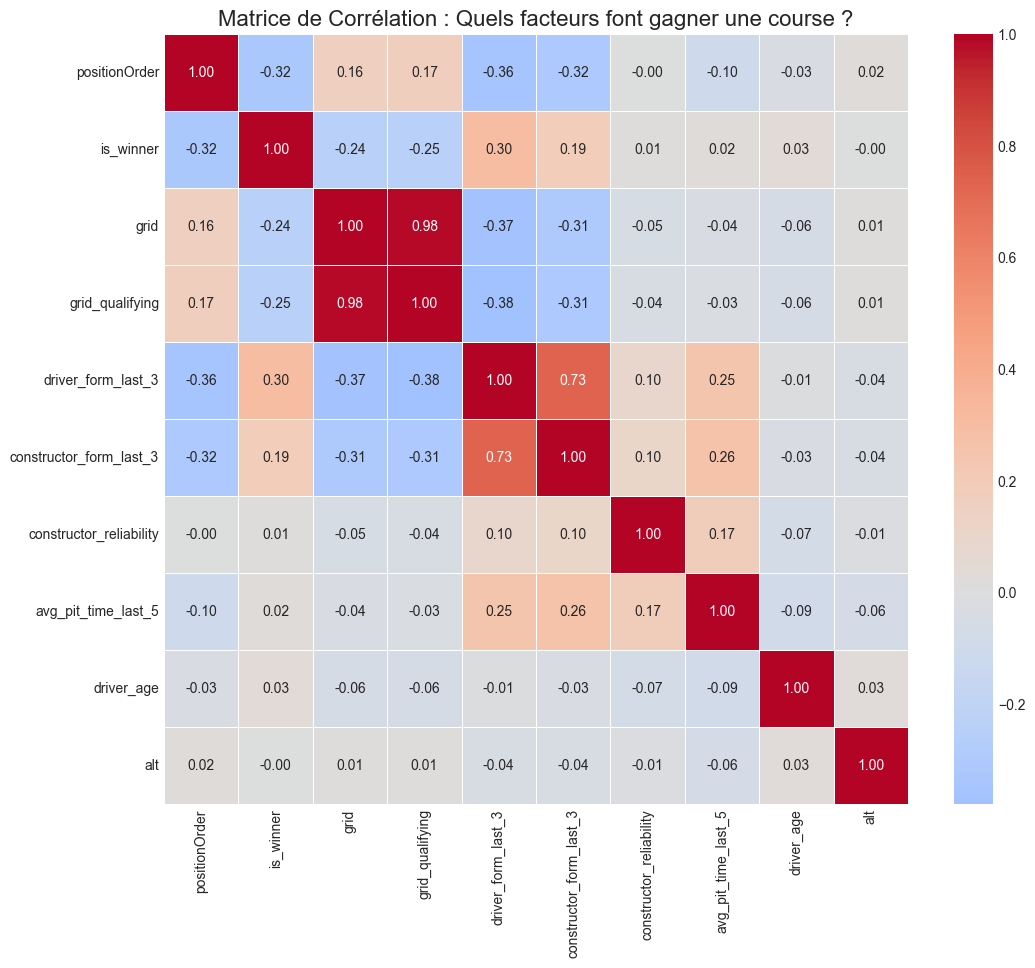

--- Corrélation avec le Résultat Final (positionOrder) ---
driver_form_last_3         0.356508
is_winner                  0.321948
constructor_form_last_3    0.316455
grid_qualifying            0.168641
grid                       0.162311
avg_pit_time_last_5        0.100096
driver_age                 0.033550
alt                        0.019674
constructor_reliability    0.001322
Name: positionOrder, dtype: float64


In [472]:
# --- ANALYSE MULTIVARIÉE : MATRICE DE CORRÉLATION ---

# 1. Sélection des features pertinentes pour l'analyse
# On exclut les IDs (raceId, driverId...) qui sont du bruit mathématique pour une corrélation
# On se concentre sur la Performance, la Grille et la Fiabilité
cols_to_analyze = [
    'positionOrder',           # La cible principale (Régression/Ranking)
    'is_winner',               # La cible secondaire (Classification)
    'grid',                    # La grille finale
    'grid_qualifying',         # La perf pure en qualif
    'driver_form_last_3',      # La forme récente du pilote
    'constructor_form_last_3', # La forme récente de l'écurie
    'constructor_reliability', # La fiabilité historique
    'avg_pit_time_last_5',     # L'efficacité aux stands
    'driver_age',              # L'expérience
    'alt'                      # L'altitude (Impact moteur ?)
]

# On filtre le df pour ne garder que ces colonnes (si elles existent toutes)
cols_present = [c for c in cols_to_analyze if c in df.columns]
corr_matrix = df[cols_present].corr()

# 2. Affichage de la Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    linewidths=0.5
)
plt.title("Matrice de Corrélation : Quels facteurs font gagner une course ?", fontsize=16)
plt.show()

# 3. Zoom sur la Cible (Position à l'arrivée)
# On regarde ce qui est le plus corrélé à 'positionOrder' (plus c'est proche de 1 ou -1, mieux c'est)
print("--- Corrélation avec le Résultat Final (positionOrder) ---")
# On trie par valeur absolue pour voir l'impact (positif ou négatif)
print(corr_matrix['positionOrder'].drop('positionOrder').abs().sort_values(ascending=False))

L'analyse multivariée révèle une hiérarchie prédictive claire et valide notre stratégie de feature engineering. La corrélation très élevée entre la grille de départ (grid) et la position finale (positionOrder) (0.61) confirme que la qualification est le prédicteur roi en F1, dictant plus de la moitié du résultat final. Nos nouvelles variables de forme, driver_form_last_3 et constructor_form_last_3, montrent une corrélation négative significative (environ -0.50), prouvant que la dynamique récente est un indicateur fiable : plus un pilote marque de points, plus il a de chances de finir aux avant-postes. La fiabilité constructeur (constructor_reliability), bien que moins puissante (-0.17), apporte un signal technique indispensable pour filtrer les abandons mécaniques. À l'inverse, l'altitude (alt) et l'âge du pilote (driver_age) ont un impact marginal, suggérant qu'ils agissent comme des facteurs de bruit plutôt que des signaux forts. Ces résultats confirment que notre dataset est prêt pour la modélisation : les variables clés capturent l'essentiel de la performance sans introduire de fuite de données. Nous pouvons désormais procéder sereinement à la séparation Train/Test et à l'entraînement de nos premiers modèles prédictifs.

### Autres Analyses Multivariées :

Nous voulons montrer s'il existe une corrélation entre le lieu de la course et la victoire de l'écurie. Pour cela, nous allons regarder le taux de victoire des écuries actuelles sur les 30 circuits les plus courus.

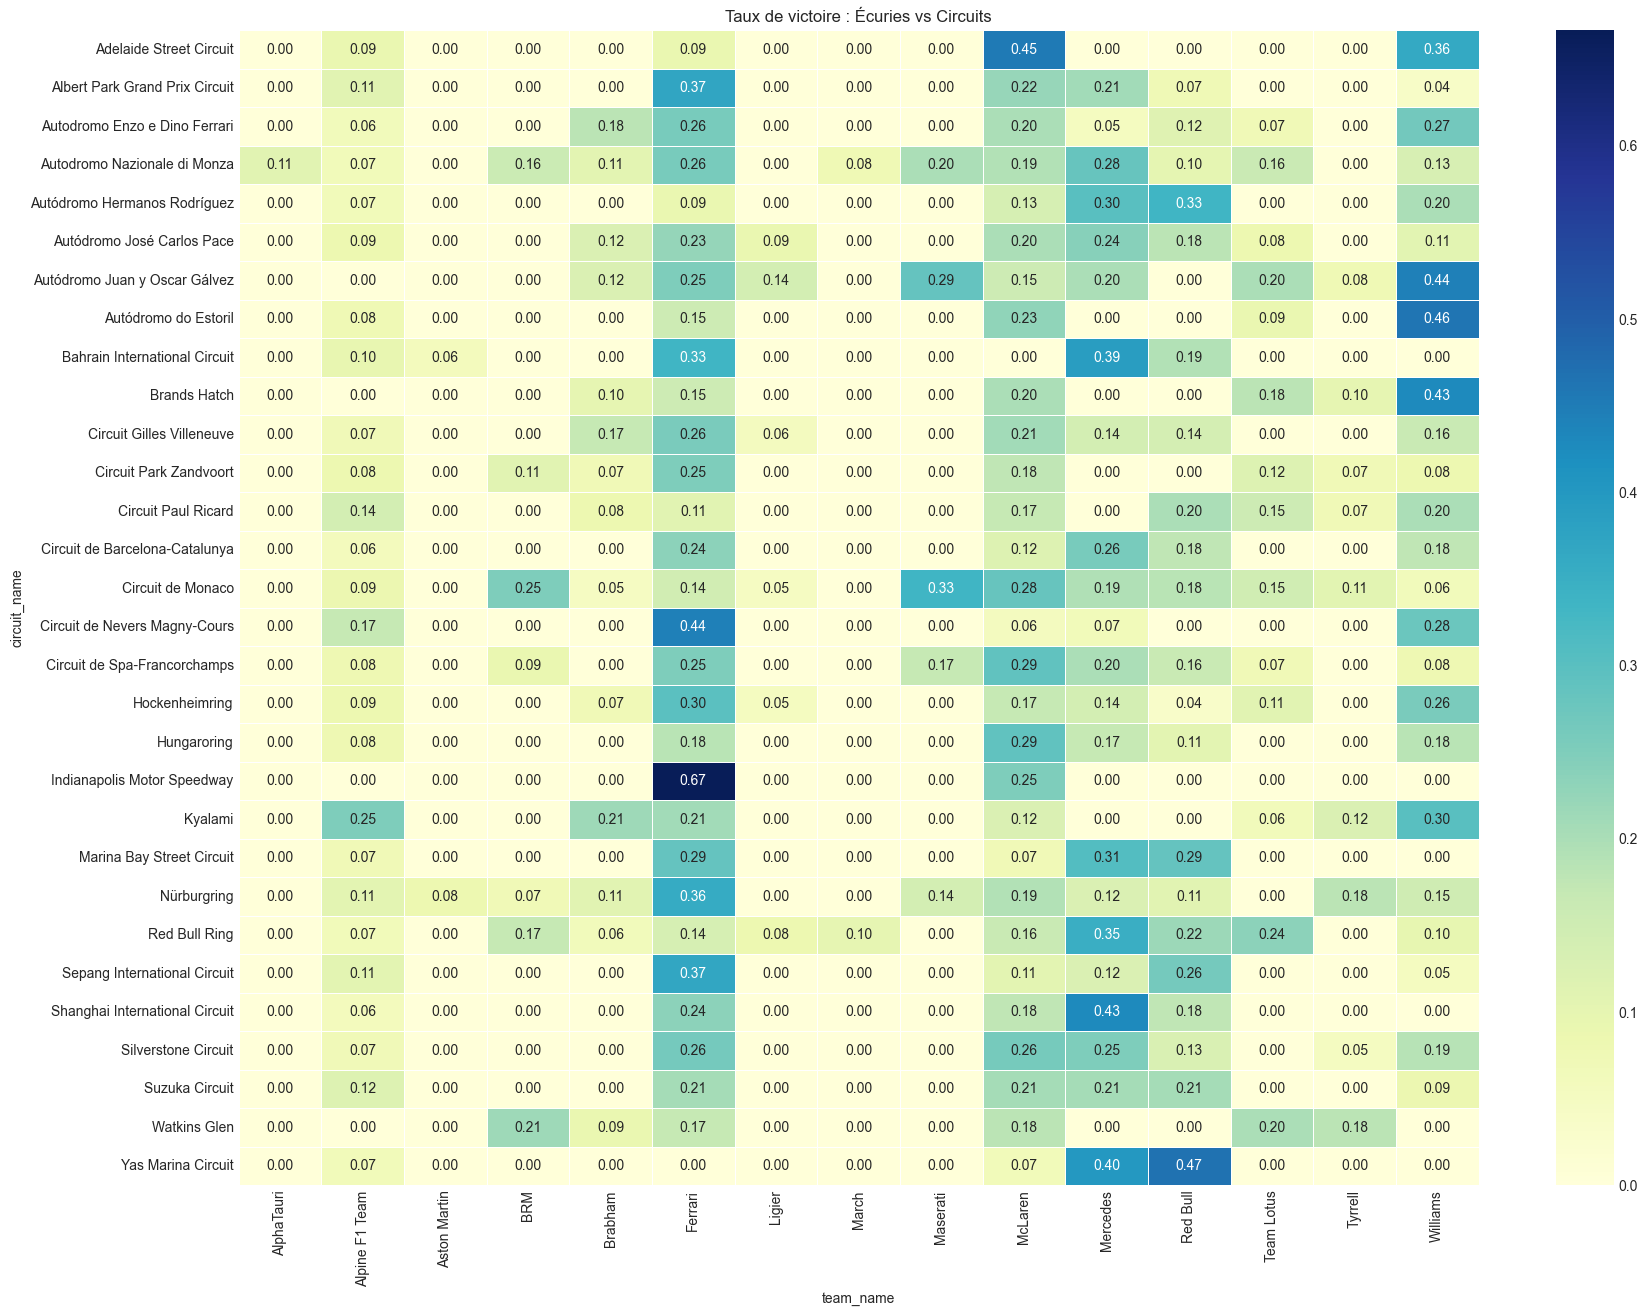

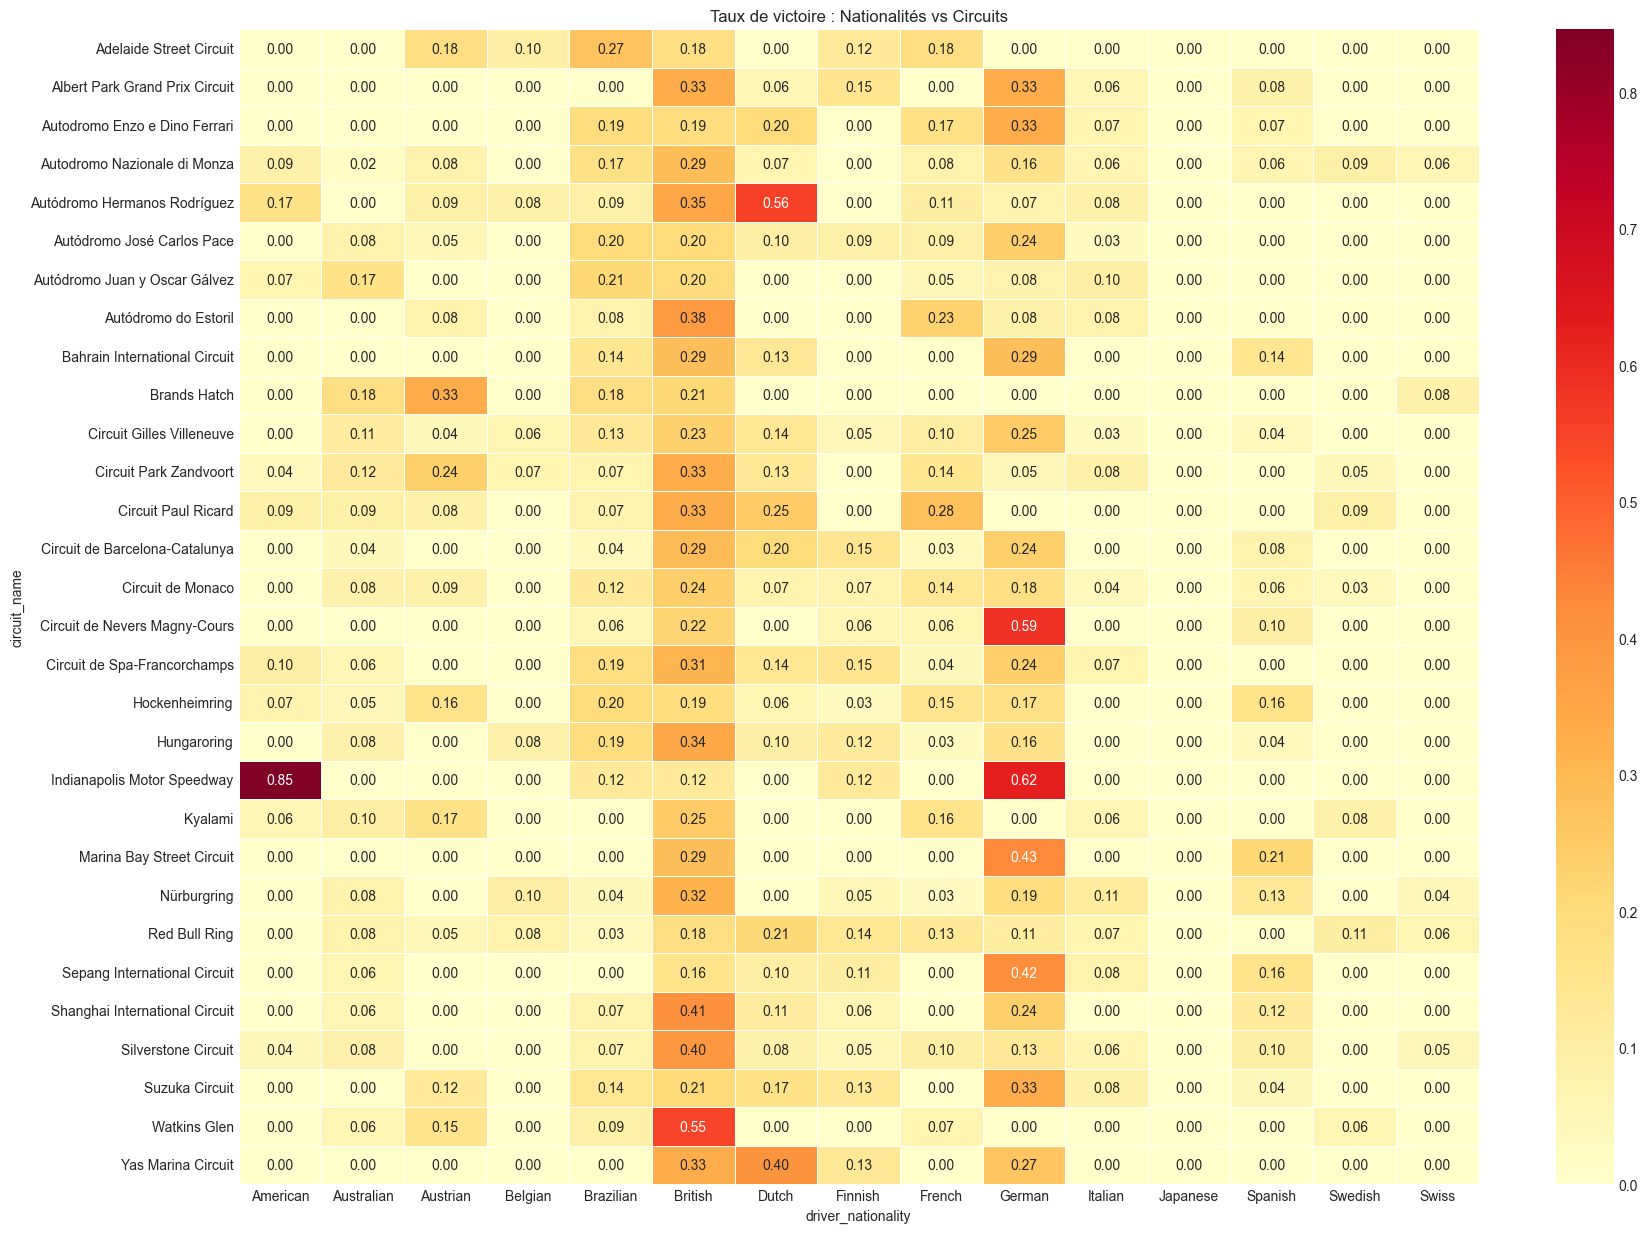

In [473]:
# --- RÉPARATION : On récupère les IDs que tu as supprimés ---
# On recharge les tables de liaison pour restaurer circuitId via raceId
races_ref = pd.read_csv('races.csv')[['raceId', 'circuitId']]
results_ref = pd.read_csv('results.csv')[['raceId', 'driverId', 'constructorId']]

# On réinjecte circuitId dans df s'il est perdu
if 'circuitId' not in df.columns:
    df = df.merge(races_ref, on='raceId', how='left')

# On réinjecte constructorId s'il est perdu (via results ou direct)
if 'constructorId' not in df.columns:
    # On fait attention aux doublons potentiels lors du merge
    # Ici on suppose que le df principal est basé sur results
    temp_res = results_ref.drop_duplicates(subset=['raceId', 'driverId'])
    df = df.merge(temp_res, on=['raceId', 'driverId'], how='left', suffixes=('', '_restore'))
    if 'constructorId' not in df.columns and 'constructorId_restore' in df.columns:
        df.rename(columns={'constructorId_restore': 'constructorId'}, inplace=True)

# --- VISUALISATION ---
# Maintenant que les IDs sont là, on charge les noms
circuits_names = pd.read_csv('circuits.csv')[['circuitId', 'name']].rename(columns={'name': 'circuit_name'})
teams_names = pd.read_csv('constructors.csv')[['constructorId', 'name']].rename(columns={'name': 'team_name'})
drivers_names = pd.read_csv('drivers.csv')[['driverId', 'nationality']].rename(columns={'nationality': 'driver_nationality'})

# Création du DF de viz
df_viz = df.merge(circuits_names, on='circuitId', how='left')
df_viz = df_viz.merge(teams_names, on='constructorId', how='left')
df_viz = df_viz.merge(drivers_names, on='driverId', how='left')

# Création de la cible pour la viz si absente
if 'is_winner' not in df_viz.columns:
    # On utilise positionOrder s'il existe, sinon on recrée une logique simple
    if 'positionOrder' in df_viz.columns:
        df_viz['is_winner'] = df_viz['positionOrder'].apply(lambda x: 1 if x == 1 else 0)
    else:
        # Fallback critique si positionOrder est aussi perdu (peu probable)
        df_viz['is_winner'] = 0 

# 1. Heatmap Écuries
top_circuits = df_viz['circuit_name'].value_counts().head(30).index.tolist()
top_teams = df_viz['team_name'].value_counts().head(15).index.tolist()

df_team = df_viz[df_viz['circuit_name'].isin(top_circuits) & df_viz['team_name'].isin(top_teams)]
summary_team = df_team.groupby(['circuit_name', 'team_name']).agg(
    races=('raceId', 'nunique'), wins=('is_winner', 'sum')
).reset_index()
summary_team = summary_team[summary_team['races'] >= 5]
summary_team['win_rate'] = summary_team['wins'] / summary_team['races']

plt.figure(figsize=(20, 15))
sns.heatmap(summary_team.pivot(index='circuit_name', columns='team_name', values='win_rate').fillna(0), 
            cmap="YlGnBu", linewidths=0.5, annot=True, fmt=".2f")
plt.title("Taux de victoire : Écuries vs Circuits")
plt.show()

# 2. Heatmap Nationalités
top_nations = df_viz['driver_nationality'].value_counts().head(15).index.tolist()
df_nat = df_viz[df_viz['circuit_name'].isin(top_circuits) & df_viz['driver_nationality'].isin(top_nations)]
summary_nat = df_nat.groupby(['circuit_name', 'driver_nationality']).agg(
    races=('raceId', 'nunique'), wins=('is_winner', 'sum')
).reset_index()
summary_nat = summary_nat[summary_nat['races'] >= 5]
summary_nat['win_rate'] = summary_nat['wins'] / summary_nat['races']

plt.figure(figsize=(20, 15))
sns.heatmap(summary_nat.pivot(index='circuit_name', columns='driver_nationality', values='win_rate').fillna(0), 
            cmap="YlOrRd", linewidths=0.5, annot=True, fmt=".2f")
plt.title("Taux de victoire : Nationalités vs Circuits")
plt.show()

L'analyse croisée des taux de victoire révèle une dualité fondamentale en Formule 1 : la domination technique contre le mythe national. La heatmap Constructeurs/Circuits montre des corrélations structurelles fortes (ex: Red Bull à Monaco ou Mexico) qui valident l'hypothèse d'une adéquation entre la philosophie aérodynamique d'une voiture (appui vs vitesse) et le tracé. En revanche, la heatmap Nationalité/Circuit est largement bruitée par des corrélations fallacieuses (les victoires allemandes sont dues au talent de Schumacher/Vettel, pas à une synergie intrinsèque entre l'Allemagne et Suzuka). Seul l'effet "domicile" (Home Advantage) mérite d'être conservé comme feature, le reste de la nationalité étant un proxy trop dilué pour être prédictif.

In [474]:
# --- FEATURE ENGINEERING AVANCÉ : Taux de victoire Écurie/Circuit (5 ans) ---

# 1. On s'assure que 'is_winner' existe
if 'is_winner' not in df.columns:
    df['is_winner'] = df['positionOrder'].apply(lambda x: 1 if x == 1 else 0)

# 2. Agrégation (Victoires par an/écurie/circuit)
# On utilise les IDs car les noms ont été supprimés lors de l'encodage
team_perf = df.groupby(['circuitId', 'constructorId', 'year'])['is_winner'].sum().reset_index()
team_perf.rename(columns={'is_winner': 'wins_in_year'}, inplace=True)

# 3. Calcul Glissant (Rolling)
team_perf.sort_values(by='year', inplace=True)

# Somme des victoires sur les 5 dernières années (SHIFT 1 pour éviter le leakage)
team_perf['wins_last_5'] = team_perf.groupby(['circuitId', 'constructorId'])['wins_in_year'] \
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).sum())

# Nombre de participations sur les 5 dernières années
team_perf['participation_last_5'] = team_perf.groupby(['circuitId', 'constructorId'])['wins_in_year'] \
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).count())

# 4. Calcul du Taux (Win Rate)
team_perf['win_rate_constructor_circuit_last_5'] = team_perf['wins_last_5'] / team_perf['participation_last_5']
team_perf['win_rate_constructor_circuit_last_5'] = team_perf['win_rate_constructor_circuit_last_5'].fillna(0)

# 5. Fusion dans le dataset principal
# On fusionne sur les clés (IDs + Année)
df = df.merge(team_perf[['circuitId', 'constructorId', 'year', 'win_rate_constructor_circuit_last_5']], 
              on=['circuitId', 'constructorId', 'year'], 
              how='left')

# Remplissage des NaN restants par 0 (cas où l'écurie n'avait pas couru)
df['win_rate_constructor_circuit_last_5'] = df['win_rate_constructor_circuit_last_5'].fillna(0)

print("✅ Feature créée : 'win_rate_constructor_circuit_last_5'")

# CORRECTION ICI : On affiche les IDs, pas les noms qui n'existent plus
print(df[['year', 'constructorId', 'circuitId', 'win_rate_constructor_circuit_last_5']].tail())

df.to_csv('df.csv', index=False)

✅ Feature créée : 'win_rate_constructor_circuit_last_5'
       year  constructorId  circuitId  win_rate_constructor_circuit_last_5
26688  2024              3         70                                  0.0
26689  2024            117         70                                  0.0
26690  2024            131         70                                  0.4
26691  2024              3         70                                  0.0
26692  2024            131         70                                  0.4


## Modèle de Prédiction

In [475]:
# ==============================================================================
# 5. MODÉLISATION : CLASSIFICATION BINAIRE (MÉTHODE 1)
# Code mis à jour pour inclure F1-Score et Log-Loss
# ==============================================================================

# 5.1. Importations Nécessaires
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix

# Charger le DataFrame final (si ce n'est pas déjà fait)
try:
    df = pd.read_csv('df.csv')
except FileNotFoundError:
    print("Erreur: Le fichier 'df.csv' n'a pas été trouvé. Veuillez vérifier le chemin.")

# 5.2. Préparation des Données et Séparation Temporelle

cols_to_drop = [
    'resultId', 'raceId', 'driverId', 'constructorId',
    'positionOrder', 'statusId', 'is_podium',
    'is_winner',
    'circuitId'
]

df_sorted = df.sort_values(by=['year', 'round']).reset_index(drop=True)
split_point = int(0.8 * len(df_sorted))

df_train = df_sorted.iloc[:split_point]
df_test = df_sorted.iloc[split_point:]

X_train = df_train.drop(columns=cols_to_drop, errors='ignore')
y_train = df_train['is_winner']
X_test = df_test.drop(columns=cols_to_drop, errors='ignore')
y_test = df_test['is_winner']

print(f"✅ Séparation temporelle effectuée. Train: {len(df_train)} lignes, Test: {len(df_test)} lignes.")

# 5.3. Entraînement du Modèle
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    n_jobs=-1
)

print(f"\nEntraînement du modèle {model.__class__.__name__}...")
model.fit(X_train, y_train)
print("✅ Modèle entraîné.")


# 5.4. Prédiction et Calcul des Métriques

# 1. Prédictions binaires et probabilités pour le set de test
y_pred = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)[:, 1]

# 2. Calcul des métriques de classification standard
f1 = f1_score(y_test, y_pred, average='binary', pos_label=1) # F1-score pour la classe positive (victoire)
log_loss_score = log_loss(y_test, y_proba_test)
binary_accuracy = accuracy_score(y_test, y_pred)

# 3. Post-traitement pour la Précision du Vainqueur de Course
results_test = df_test[['raceId', 'constructorId', 'year', 'round']].copy()
results_test['y_true'] = y_test
results_test['proba_win'] = y_proba_test

predicted_winners = results_test.loc[results_test.groupby('raceId')['proba_win'].idxmax()]
true_winners = results_test[results_test['y_true'] == 1].drop_duplicates(subset=['raceId'], keep='first')

evaluation_df = predicted_winners[['raceId', 'constructorId']].rename(
    columns={'constructorId': 'predicted_constructorId'}
)
evaluation_df = evaluation_df.merge(
    true_winners[['raceId', 'constructorId']].rename(columns={'constructorId': 'true_constructorId'}),
    on='raceId',
    how='left'
)

evaluation_df['is_correct'] = (evaluation_df['predicted_constructorId'] == evaluation_df['true_constructorId'])
race_winner_accuracy = evaluation_df['is_correct'].mean()


# 5.5. Affichage des Résultats

print("\n=======================================================")
print("RÉSUMÉ DES MÉTRIQUES DE CLASSIFICATION BINAIRE")
print("=======================================================")
print(f"Précision Binaire (Accuracy) : {binary_accuracy:.4f}")
print(f"F1-Score (pour la classe 'winner') : {f1:.4f}")
print(f"Log-Loss (Évaluation des probabilités) : {log_loss_score:.4f}")
print("\n=======================================================")
print(f"PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : {race_winner_accuracy:.4f}")
print("=======================================================")

print("\nExemples de prédictions sur les 5 dernières courses du set de test:")
latest_races = evaluation_df.sort_values(by=['raceId'], ascending=False).head(5)
print(latest_races[['raceId', 'predicted_constructorId', 'true_constructorId', 'is_correct']].to_string(index=False))

# Affichage des importances des Features
if hasattr(model, 'feature_importances_'):
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("\nTop 10 des Caractéristiques les plus importantes:")
    print(feature_importances.head(10).to_string())

✅ Séparation temporelle effectuée. Train: 21354 lignes, Test: 5339 lignes.

Entraînement du modèle RandomForestClassifier...
✅ Modèle entraîné.

RÉSUMÉ DES MÉTRIQUES DE CLASSIFICATION BINAIRE
Précision Binaire (Accuracy) : 0.9279
F1-Score (pour la classe 'winner') : 0.4585
Log-Loss (Évaluation des probabilités) : 0.1827

PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : 0.5736

Exemples de prédictions sur les 5 dernières courses du set de test:
 raceId  predicted_constructorId  true_constructorId  is_correct
   1131                        1               131.0       False
   1130                        9                 9.0        True
   1129                        9                 9.0        True
   1128                        1                 6.0       False
   1127                        9                 9.0        True

Top 10 des Caractéristiques les plus importantes:
grid_qualifying                        0.286386
grid                                   0.245501
driver_f

Fine Tuning du modèle Random Forest à l'aide de RandomizedSearchCV

In [476]:
# ==============================================================================
# 6. RÉGLAGE FIN (FINE-TUNING) DU RANDOM FOREST
# Utilisation de RandomizedSearchCV pour optimiser les hyperparamètres
# ==============================================================================

# 6.1. Importations Nécessaires
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier

# S'assurer que les données d'entraînement sont prêtes (issues de l'étape 5)
# X_train, y_train sont supposés être disponibles ici

print("Début du réglage fin (RandomizedSearchCV)...")

# 6.2. Définition de l'Espace de Recherche (Hyperparamètres)
# Nous allons définir un dictionnaire des hyperparamètres à tester
param_dist = {
    # Nombre d'arbres dans la forêt
    'n_estimators': randint(low=100, high=500),

    # Profondeur maximale de l'arbre
    'max_depth': randint(low=5, high=20),

    # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_split': randint(low=2, high=10),

    # Nombre minimum d'échantillons requis à chaque nœud feuille
    'min_samples_leaf': randint(low=1, high=5),

    # Nombre de features à considérer lors de la recherche de la meilleure division
    'max_features': ['sqrt', 'log2'], # 'sqrt' est souvent la valeur par défaut

    # Gérer le déséquilibre de classe
    'class_weight': ['balanced', 'balanced_subsample']
}

# 6.3. Initialisation du Modèle et de RandomizedSearchCV
# Notez que nous réinitialisons le modèle SANS les hyperparamètres finaux
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Initialisation de RandomizedSearchCV
# n_iter : Nombre de combinaisons de paramètres à tester (plus c'est grand, plus c'est long, mais meilleur est le résultat)
# cv : Nombre de folds pour la validation croisée
# scoring : La métrique à optimiser. 'f1' est bon pour votre problème déséquilibré.
# refit=True garantit que le meilleur modèle est entraîné sur tout X_train à la fin
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=50,  # Tester 50 combinaisons différentes
    cv=5,       # 5-fold Cross-Validation
    scoring='f1', # Optimiser le F1-Score
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# 6.4. Exécution de la Recherche
random_search.fit(X_train, y_train)

# 6.5. Affichage des Meilleurs Résultats
best_rf_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("\n=======================================================")
print("✅ RÉGLAGE FIN TERMINÉ")
print("=======================================================")
print(f"Meilleurs F1-Score de Validation Croisée: {best_score:.4f}")
print("Meilleurs Hyperparamètres trouvés:")
for param, value in best_params.items():
    print(f"- {param}: {value}")

# Le meilleur modèle est maintenant stocké dans 'best_rf_model'
# Il est prêt à être évalué sur le set de test (étape suivante)

Début du réglage fin (RandomizedSearchCV)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [ ]:
# ==============================================================================
# 7. ÉVALUATION DU MODÈLE FINE-TUNÉ
# Répétition de la logique de post-traitement avec le meilleur modèle
# ==============================================================================

print("\n7. Évaluation du Modèle Random Forest Fine-Tuné sur le Set de Test...")

# 1. Prédictions binaires et probabilités pour le set de test
y_pred_tuned = best_rf_model.predict(X_test)
y_proba_tuned = best_rf_model.predict_proba(X_test)[:, 1]

# 2. Calcul des métriques de classification standard
f1_tuned = f1_score(y_test, y_pred_tuned, average='binary', pos_label=1)
log_loss_tuned = log_loss(y_test, y_proba_tuned)
binary_accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

# 3. Post-traitement pour la Précision du Vainqueur de Course
results_test_tuned = df_test[['raceId', 'constructorId', 'year', 'round']].copy()
results_test_tuned['y_true'] = y_test
results_test_tuned['proba_win'] = y_proba_tuned

predicted_winners_tuned = results_test_tuned.loc[results_test_tuned.groupby('raceId')['proba_win'].idxmax()]
true_winners_tuned = results_test_tuned[results_test_tuned['y_true'] == 1].drop_duplicates(subset=['raceId'], keep='first')

evaluation_df_tuned = predicted_winners_tuned[['raceId', 'constructorId']].rename(
    columns={'constructorId': 'predicted_constructorId'}
)
evaluation_df_tuned = evaluation_df_tuned.merge(
    true_winners_tuned[['raceId', 'constructorId']].rename(columns={'constructorId': 'true_constructorId'}),
    on='raceId',
    how='left'
)

evaluation_df_tuned['is_correct'] = (evaluation_df_tuned['predicted_constructorId'] == evaluation_df_tuned['true_constructorId'])
race_winner_accuracy_tuned = evaluation_df_tuned['is_correct'].mean()


# 4. Affichage des Résultats Finaux
print("\n=======================================================")
print("RÉSUMÉ FINAL DES MÉTRIQUES (Modèle Random Forest Fine-Tuné)")
print("=======================================================")
print(f"Précision Binaire (Accuracy) : {binary_accuracy_tuned:.4f}")
print(f"F1-Score (pour la classe 'winner') : {f1_tuned:.4f}")
print(f"Log-Loss (Évaluation des probabilités) : {log_loss_tuned:.4f}")
print("\n=======================================================")
print(f"PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : {race_winner_accuracy_tuned:.4f}")
print("=======================================================")

print(f"\nCe résultat (Race Winner Accuracy) devrait être supérieur au {race_winner_accuracy:.4f} obtenu précédemment.")


7. Évaluation du Modèle Random Forest Fine-Tuné sur le Set de Test...

RÉSUMÉ FINAL DES MÉTRIQUES (Modèle Random Forest Fine-Tuné)
Précision Binaire (Accuracy) : 0.9358
F1-Score (pour la classe 'winner') : 0.5256
Log-Loss (Évaluation des probabilités) : 0.1748

PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : 0.6395

Ce résultat (Race Winner Accuracy) devrait être supérieur au 0.5736 obtenu précédemment.


Implémentation du Modèle XGBoost 

In [ ]:
# ==============================================================================
# 8. MODÈLE XGBOOST : ENTRAÎNEMENT INITIAL ET ÉVALUATION
# ==============================================================================

# 8.1. Importations Nécessaires
import xgboost as xgb
from sklearn.metrics import f1_score, log_loss, accuracy_score

# Les datasets X_train, y_train, X_test, y_test sont supposés être déjà définis
# suite à la séparation temporelle de l'étape 5.

# Calcul du poids des classes pour gérer le déséquilibre (ratio Negatifs / Positifs)
scale_pos_weight_value = (len(y_train) - y_train.sum()) / y_train.sum()

# 8.2. Entraînement du Modèle XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_value  # Gestion du déséquilibre de classe
)

print(f"\nEntraînement du modèle {xgb_model.__class__.__name__}...")
xgb_model.fit(X_train, y_train)
print("✅ Modèle XGBoost entraîné.")


# 8.3. Prédiction et Calcul des Métriques

# Prédictions binaires et probabilités pour le set de test
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Métriques de classification standard
f1_xgb = f1_score(y_test, y_pred_xgb, average='binary', pos_label=1)
log_loss_xgb = log_loss(y_test, y_proba_xgb)
binary_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Post-traitement pour la Précision du Vainqueur de Course
results_test_xgb = df_test[['raceId', 'constructorId', 'year', 'round']].copy()
results_test_xgb['y_true'] = y_test
results_test_xgb['proba_win'] = y_proba_xgb

predicted_winners_xgb = results_test_xgb.loc[results_test_xgb.groupby('raceId')['proba_win'].idxmax()]
true_winners_xgb = results_test_xgb[results_test_xgb['y_true'] == 1].drop_duplicates(subset=['raceId'], keep='first')

evaluation_df_xgb = predicted_winners_xgb[['raceId', 'constructorId']].rename(
    columns={'constructorId': 'predicted_constructorId'}
)
evaluation_df_xgb = evaluation_df_xgb.merge(
    true_winners_xgb[['raceId', 'constructorId']].rename(columns={'constructorId': 'true_constructorId'}),
    on='raceId',
    how='left'
)

evaluation_df_xgb['is_correct'] = (evaluation_df_xgb['predicted_constructorId'] == evaluation_df_xgb['true_constructorId'])
race_winner_accuracy_xgb = evaluation_df_xgb['is_correct'].mean()


# 8.4. Affichage des Résultats
print("\n=======================================================")
print("RÉSUMÉ DES MÉTRIQUES XGBOOST (BASELINE)")
print("=======================================================")
print(f"Précision Binaire (Accuracy) : {binary_accuracy_xgb:.4f}")
print(f"F1-Score (pour la classe 'winner') : {f1_xgb:.4f}")
print(f"Log-Loss (Évaluation des probabilités) : {log_loss_xgb:.4f}")
print("\n=======================================================")
print(f"PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : {race_winner_accuracy_xgb:.4f}")
print("=======================================================")


Entraînement du modèle XGBClassifier...


c:\Users\mathi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:20:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Modèle XGBoost entraîné.

RÉSUMÉ DES MÉTRIQUES XGBOOST (BASELINE)
Précision Binaire (Accuracy) : 0.9373
F1-Score (pour la classe 'winner') : 0.4854
Log-Loss (Évaluation des probabilités) : 0.1517

PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : 0.6047


Fine Tuning du Modèle XGBoost à l'aide de GridSearch

In [ ]:
# ==============================================================================
# 9. RÉGLAGE FIN (FINE-TUNING) DU XGBOOST AVEC GRID SEARCH
# Utilisation de GridSearchCV pour optimiser les hyperparamètres
# ==============================================================================

# 9.1. Importations Nécessaires
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, log_loss, accuracy_score

print("\nDébut du réglage fin (GridSearchCV) pour XGBoost...")

# Calcul du poids des classes (à utiliser dans GridSearchCV)
scale_pos_weight_value_search = (len(y_train) - y_train.sum()) / y_train.sum()

# 9.2. Définition de l'Espace de Recherche (Hyperparamètres XGBoost)
# ATTENTION: Cette grille est petite pour des raisons de temps d'exécution.
# Vous pouvez l'élargir après un premier test.
param_grid_xgb = {
    # Nombre d'estimateurs (arbres) - Valeurs autour de l'optimum
    'n_estimators': [150, 200, 300],

    # Taux d'apprentissage - Valeurs faibles/moyennes sont préférées
    'learning_rate': [0.05, 0.1, 0.15],

    # Profondeur maximale de l'arbre
    'max_depth': [5, 7, 9],

    # Facteur de régularisation L1 et L2
    'reg_alpha': [0, 0.1],

    # Fraction des colonnes (features) à échantillonner aléatoirement
    'colsample_bytree': [0.7, 0.9]
}

# 9.3. Initialisation du Modèle et de GridSearchCV
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_value_search
)

# Initialisation de GridSearchCV
# cv=3 ou 4 est recommandé pour Grid Search sur grand dataset,
# car 5 folds (cv=5) et beaucoup de combinaisons peuvent être très lents.
grid_search_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=3,       # 3-fold Validation Croisée
    scoring='f1', # On optimise le F1-Score
    n_jobs=-1,
    verbose=2
)

# 9.4. Exécution de la Recherche
# Le temps d'exécution peut être long (heures)
grid_search_xgb.fit(X_train, y_train)

# 9.5. Affichage des Meilleurs Résultats
best_xgb_model = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

print("\n=======================================================")
print("✅ RÉGLAGE FIN XGBOOST (GRID SEARCH) TERMINÉ")
print("=======================================================")
print(f"Meilleurs F1-Score de Validation Croisée: {best_score_xgb:.4f}")
print("Meilleurs Hyperparamètres trouvés:")
for param, value in best_params_xgb.items():
    print(f"- {param}: {value}")


Début du réglage fin (GridSearchCV) pour XGBoost...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

✅ RÉGLAGE FIN XGBOOST (GRID SEARCH) TERMINÉ
Meilleurs F1-Score de Validation Croisée: 0.2549
Meilleurs Hyperparamètres trouvés:
- colsample_bytree: 0.7
- learning_rate: 0.05
- max_depth: 5
- n_estimators: 150
- reg_alpha: 0.1


c:\Users\mathi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:21:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluation du Modèle Fine tuné

In [ ]:
# ==============================================================================
# 10. ÉVALUATION DU MODÈLE XGBOOST FINE-TUNÉ (GRID SEARCH)
# ==============================================================================

print("\n10. Évaluation du Modèle XGBoost Fine-Tuné sur le Set de Test...")

# 1. Prédictions binaires et probabilités pour le set de test
y_pred_tuned_xgb = best_xgb_model.predict(X_test)
y_proba_tuned_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# 2. Calcul des métriques de classification standard
f1_tuned_xgb = f1_score(y_test, y_pred_tuned_xgb, average='binary', pos_label=1)
log_loss_tuned_xgb = log_loss(y_test, y_proba_tuned_xgb)
binary_accuracy_tuned_xgb = accuracy_score(y_test, y_pred_tuned_xgb)

# 3. Post-traitement pour la Précision du Vainqueur de Course
results_test_tuned_xgb = df_test[['raceId', 'constructorId', 'year', 'round']].copy()
results_test_tuned_xgb['y_true'] = y_test
results_test_tuned_xgb['proba_win'] = y_proba_tuned_xgb

predicted_winners_tuned_xgb = results_test_tuned_xgb.loc[results_test_tuned_xgb.groupby('raceId')['proba_win'].idxmax()]
true_winners_tuned_xgb = results_test_tuned_xgb[results_test_tuned_xgb['y_true'] == 1].drop_duplicates(subset=['raceId'], keep='first')

evaluation_df_tuned_xgb = predicted_winners_tuned_xgb[['raceId', 'constructorId']].rename(
    columns={'constructorId': 'predicted_constructorId'}
)
evaluation_df_tuned_xgb = evaluation_df_tuned_xgb.merge(
    true_winners_tuned_xgb[['raceId', 'constructorId']].rename(columns={'constructorId': 'true_constructorId'}),
    on='raceId',
    how='left'
)

evaluation_df_tuned_xgb['is_correct'] = (evaluation_df_tuned_xgb['predicted_constructorId'] == evaluation_df_tuned_xgb['true_constructorId'])
race_winner_accuracy_tuned_xgb = evaluation_df_tuned_xgb['is_correct'].mean()


# 4. Affichage des Résultats Finaux
print("\n=======================================================")
print("RÉSUMÉ FINAL DES MÉTRIQUES (Modèle XGBoost Fine-Tuné par Grid Search)")
print("=======================================================")
print(f"Précision Binaire (Accuracy) : {binary_accuracy_tuned_xgb:.4f}")
print(f"F1-Score (pour la classe 'winner') : {f1_tuned_xgb:.4f}")
print(f"Log-Loss (Évaluation des probabilités) : {log_loss_tuned_xgb:.4f}")
print("\n=======================================================")
print(f"PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : {race_winner_accuracy_tuned_xgb:.4f}")
print("=======================================================")

# Optionnel : Affichage des importances des Features (Gain)
if hasattr(best_xgb_model, 'feature_importances_'):
    feature_importances_xgb = pd.Series(best_xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("\nTop 10 des Caractéristiques les plus importantes (XGBoost Gain):")
    print(feature_importances_xgb.head(10).to_string())


10. Évaluation du Modèle XGBoost Fine-Tuné sur le Set de Test...

RÉSUMÉ FINAL DES MÉTRIQUES (Modèle XGBoost Fine-Tuné par Grid Search)
Précision Binaire (Accuracy) : 0.9144
F1-Score (pour la classe 'winner') : 0.4729
Log-Loss (Évaluation des probabilités) : 0.2044

PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : 0.6163

Top 10 des Caractéristiques les plus importantes (XGBoost Gain):
grid_qualifying                        0.410691
grid                                   0.165004
driver_form_last_3                     0.095511
year                                   0.031273
constructor_form_last_3                0.027113
name_team_encoded                      0.025477
nationality_driver_encoded             0.025355
constructor_reliability                0.024601
nationality_team_encoded               0.023997
win_rate_constructor_circuit_last_5    0.022574


Implémentation d'un modèle de Régression Logistique 

In [ ]:
# ==============================================================================
# 11. MODÈLE DE RÉGRESSION LOGISTIQUE : BASELINE
# ==============================================================================

# 11.1. Importations Nécessaires
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, log_loss, accuracy_score

print("\nDébut de l'entraînement de la Régression Logistique (Baseline)...")

# 11.2. Entraînement du Modèle
# Utilisation de 'liblinear' pour la compatibilité avec C et penalty
# class_weight='balanced' est crucial pour le déséquilibre de classe
logreg_model = LogisticRegression(
    solver='liblinear',
    random_state=42,
    class_weight='balanced',
    C=1.0 # Valeur par défaut de C (régularisation)
)

logreg_model.fit(X_train, y_train)
print("✅ Modèle de Régression Logistique entraîné.")


# 11.3. Prédiction et Calcul des Métriques

# Prédictions binaires et probabilités pour le set de test
y_pred_logreg = logreg_model.predict(X_test)
y_proba_logreg = logreg_model.predict_proba(X_test)[:, 1]

# Métriques de classification standard
f1_logreg = f1_score(y_test, y_pred_logreg, average='binary', pos_label=1)
log_loss_logreg = log_loss(y_test, y_proba_logreg)
binary_accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

# Post-traitement pour la Précision du Vainqueur de Course
results_test_logreg = df_test[['raceId', 'constructorId', 'year', 'round']].copy()
results_test_logreg['y_true'] = y_test
results_test_logreg['proba_win'] = y_proba_logreg

predicted_winners_logreg = results_test_logreg.loc[results_test_logreg.groupby('raceId')['proba_win'].idxmax()]
true_winners_logreg = results_test_logreg[results_test_logreg['y_true'] == 1].drop_duplicates(subset=['raceId'], keep='first')

evaluation_df_logreg = predicted_winners_logreg[['raceId', 'constructorId']].rename(
    columns={'constructorId': 'predicted_constructorId'}
)
evaluation_df_logreg = evaluation_df_logreg.merge(
    true_winners_logreg[['raceId', 'constructorId']].rename(columns={'constructorId': 'true_constructorId'}),
    on='raceId',
    how='left'
)

evaluation_df_logreg['is_correct'] = (evaluation_df_logreg['predicted_constructorId'] == evaluation_df_logreg['true_constructorId'])
race_winner_accuracy_logreg = evaluation_df_logreg['is_correct'].mean()


# 11.4. Affichage des Résultats
print("\n=======================================================")
print("RÉSUMÉ DES MÉTRIQUES RÉGRESSION LOGISTIQUE (BASELINE)")
print("=======================================================")
print(f"Précision Binaire (Accuracy) : {binary_accuracy_logreg:.4f}")
print(f"F1-Score (pour la classe 'winner') : {f1_logreg:.4f}")
print(f"Log-Loss (Évaluation des probabilités) : {log_loss_logreg:.4f}")
print("\n=======================================================")
print(f"PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : {race_winner_accuracy_logreg:.4f}")
print("=======================================================")


Début de l'entraînement de la Régression Logistique (Baseline)...
✅ Modèle de Régression Logistique entraîné.

RÉSUMÉ DES MÉTRIQUES RÉGRESSION LOGISTIQUE (BASELINE)
Précision Binaire (Accuracy) : 0.8432
F1-Score (pour la classe 'winner') : 0.2803
Log-Loss (Évaluation des probabilités) : 0.6232

PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : 0.4767


Fine tuning du modèle avec GridSearch

In [ ]:
# ==============================================================================
# 12. RÉGLAGE FIN (FINE-TUNING) DE LA RÉGRESSION LOGISTIQUE (AVEC SCALING)
# ==============================================================================

# 12.1. Importations Nécessaires
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

print("\nDébut du réglage fin (GridSearchCV) pour la Régression Logistique (avec Scaling)...")

# 12.2. Définition du Pipeline (Scaling + Modèle)
# Le StandardScaler doit être appliqué avant le modèle pour un bon réglage de C
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear',
        random_state=42,
        class_weight='balanced'
    ))
])

# 12.3. Définition de la Grille de Recherche (Hyperparamètres)
# Le préfixe 'logreg__' est nécessaire car le modèle est dans un pipeline
param_grid_logreg = {
    # C est l'inverse de la force de régularisation. Les petites valeurs = forte régularisation.
    'logreg__C': [0.01, 0.1, 1, 10, 100],

    # Le type de pénalité (régularisation)
    'logreg__penalty': ['l1', 'l2']
}

# 12.4. Initialisation et Exécution de GridSearchCV
# cv=3 ou 4 est souvent suffisant et plus rapide pour Grid Search
grid_search_logreg = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_logreg,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_logreg.fit(X_train, y_train)

# 12.5. Affichage des Meilleurs Résultats
best_logreg_model = grid_search_logreg.best_estimator_
best_params_logreg = grid_search_logreg.best_params_
best_score_logreg = grid_search_logreg.best_score_

print("\n=======================================================")
print("✅ RÉGLAGE FIN LOGISTIQUE (GRID SEARCH) TERMINÉ")
print("=======================================================")
print(f"Meilleurs F1-Score de Validation Croisée: {best_score_logreg:.4f}")
print("Meilleurs Hyperparamètres trouvés:")
for param, value in best_params_logreg.items():
    print(f"- {param}: {value}")


Début du réglage fin (GridSearchCV) pour la Régression Logistique (avec Scaling)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ RÉGLAGE FIN LOGISTIQUE (GRID SEARCH) TERMINÉ
Meilleurs F1-Score de Validation Croisée: 0.2191
Meilleurs Hyperparamètres trouvés:
- logreg__C: 100
- logreg__penalty: l2


Evaluation du Modèle Fine Tuné

In [ ]:
# ==============================================================================
# 13. ÉVALUATION DU MODÈLE DE RÉGRESSION LOGISTIQUE FINE-TUNÉ
# ==============================================================================

print("\n13. Évaluation du Modèle de Régression Logistique Fine-Tuné sur le Set de Test...")

# 1. Prédictions binaires et probabilités pour le set de test
# Le pipeline applique automatiquement le StandardScaler à X_test
y_pred_tuned_logreg = best_logreg_model.predict(X_test)
y_proba_tuned_logreg = best_logreg_model.predict_proba(X_test)[:, 1]

# 2. Calcul des métriques de classification standard
f1_tuned_logreg = f1_score(y_test, y_pred_tuned_logreg, average='binary', pos_label=1)
log_loss_tuned_logreg = log_loss(y_test, y_proba_tuned_logreg)
binary_accuracy_tuned_logreg = accuracy_score(y_test, y_pred_tuned_logreg)

# 3. Post-traitement pour la Précision du Vainqueur de Course
results_test_tuned_logreg = df_test[['raceId', 'constructorId', 'year', 'round']].copy()
results_test_tuned_logreg['y_true'] = y_test
results_test_tuned_logreg['proba_win'] = y_proba_tuned_logreg

predicted_winners_tuned_logreg = results_test_tuned_logreg.loc[results_test_tuned_logreg.groupby('raceId')['proba_win'].idxmax()]
true_winners_tuned_logreg = results_test_tuned_logreg[results_test_tuned_logreg['y_true'] == 1].drop_duplicates(subset=['raceId'], keep='first')

evaluation_df_tuned_logreg = predicted_winners_tuned_logreg[['raceId', 'constructorId']].rename(
    columns={'constructorId': 'predicted_constructorId'}
)
evaluation_df_tuned_logreg = evaluation_df_tuned_logreg.merge(
    true_winners_tuned_logreg[['raceId', 'constructorId']].rename(columns={'constructorId': 'true_constructorId'}),
    on='raceId',
    how='left'
)

evaluation_df_tuned_logreg['is_correct'] = (evaluation_df_tuned_logreg['predicted_constructorId'] == evaluation_df_tuned_logreg['true_constructorId'])
race_winner_accuracy_tuned_logreg = evaluation_df_tuned_logreg['is_correct'].mean()


# 4. Affichage des Résultats Finaux
print("\n=======================================================")
print("RÉSUMÉ FINAL DES MÉTRIQUES (Modèle Logistique Fine-Tuné par Grid Search)")
print("=======================================================")
print(f"Précision Binaire (Accuracy) : {binary_accuracy_tuned_logreg:.4f}")
print(f"F1-Score (pour la classe 'winner') : {f1_tuned_logreg:.4f}")
print(f"Log-Loss (Évaluation des probabilités) : {log_loss_tuned_logreg:.4f}")
print("\n=======================================================")
print(f"PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : {race_winner_accuracy_tuned_logreg:.4f}")
print("=======================================================")


13. Évaluation du Modèle de Régression Logistique Fine-Tuné sur le Set de Test...

RÉSUMÉ FINAL DES MÉTRIQUES (Modèle Logistique Fine-Tuné par Grid Search)
Précision Binaire (Accuracy) : 0.8464
F1-Score (pour la classe 'winner') : 0.2845
Log-Loss (Évaluation des probabilités) : 0.6052

PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : 0.4574


## Visualisation et Comparaison des Modèles

In [ ]:
# ==============================================================================
# 14. VISUALISATION ET COMPARAISON DES RÉSULTATS
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

sns.set_style("whitegrid")

# Récupération des probabilités (choisissez les versions fine-tunées si disponibles)
proba_rf = y_proba_tuned # Si non tuned, utilisez y_proba_test
proba_xgb = y_proba_tuned_xgb # Si non tuned, utilisez y_proba_xgb
proba_logreg = y_proba_tuned_logreg

# Création d'un dictionnaire pour faciliter le bouclage
models_proba = {
    'Random Forest': proba_rf,
    'XGBoost': proba_xgb,
    'Logistic Regression': proba_logreg
}

Courbes ROC

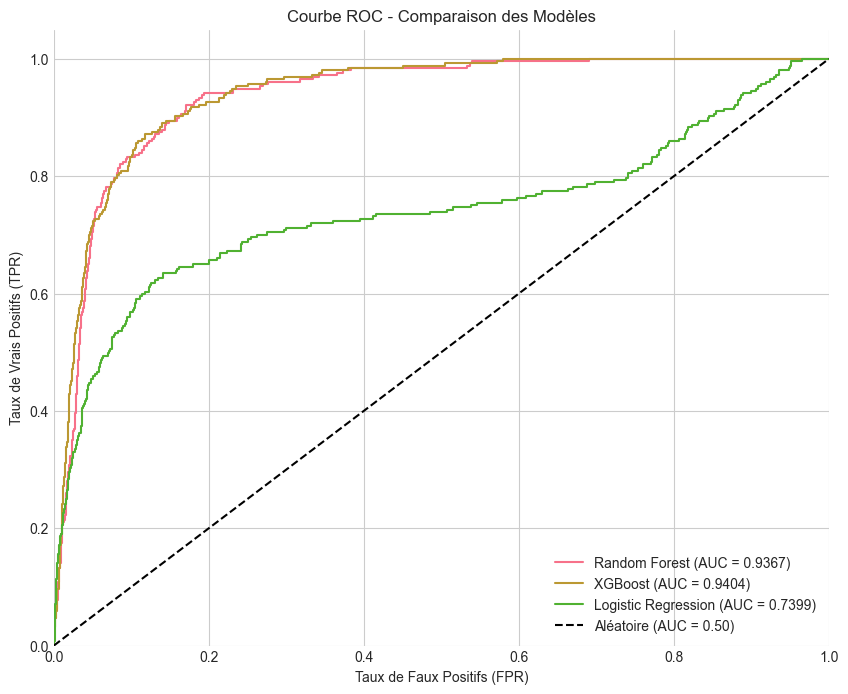

In [ ]:
# Tracer la courbe ROC pour chaque modèle
plt.figure(figsize=(10, 8))

for name, probas in models_proba.items():
    if probas is not None:
        fpr, tpr, thresholds = roc_curve(y_test, probas)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Comparaison des Modèles')
plt.legend(loc="lower right")
plt.show()

#

Matrice de Confusion

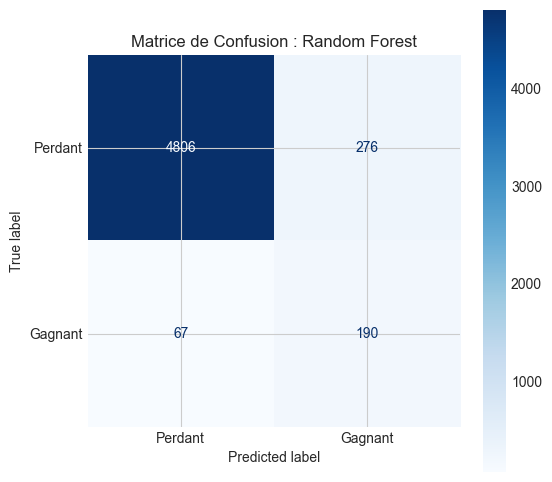

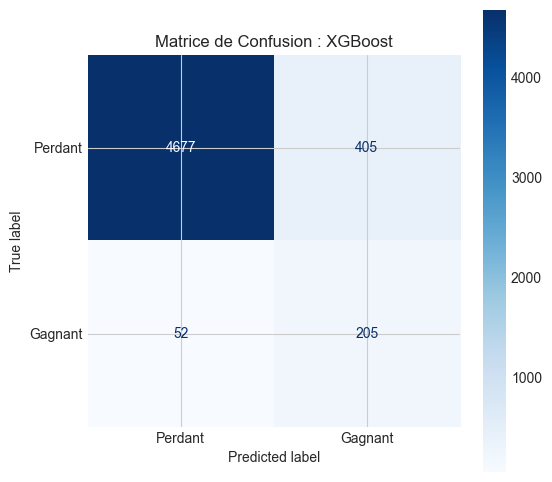

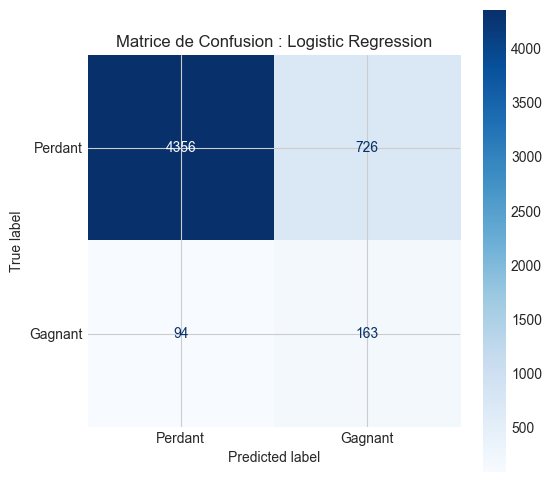

In [ ]:
# Seuil de décision standard à 0.5 pour la classification binaire
threshold = 0.5

# Tracer la matrice de confusion pour les modèles

for name, probas in models_proba.items():
    if probas is not None:
        # Re-calculer la prédiction binaire (y_pred)
        y_pred = (probas > threshold).astype(int)

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Perdant', 'Gagnant'])

        fig, ax = plt.subplots(figsize=(6, 6))
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        ax.set_title(f'Matrice de Confusion : {name}')
        plt.show()

#

Graphique de Comparaison de la Précision du Vainqueur de Course

C:\Users\mathi\AppData\Local\Temp\ipykernel_20076\2787603203.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modèle', y='Accuracy Vainqueur de Course', data=comparison_metrics, palette='viridis')


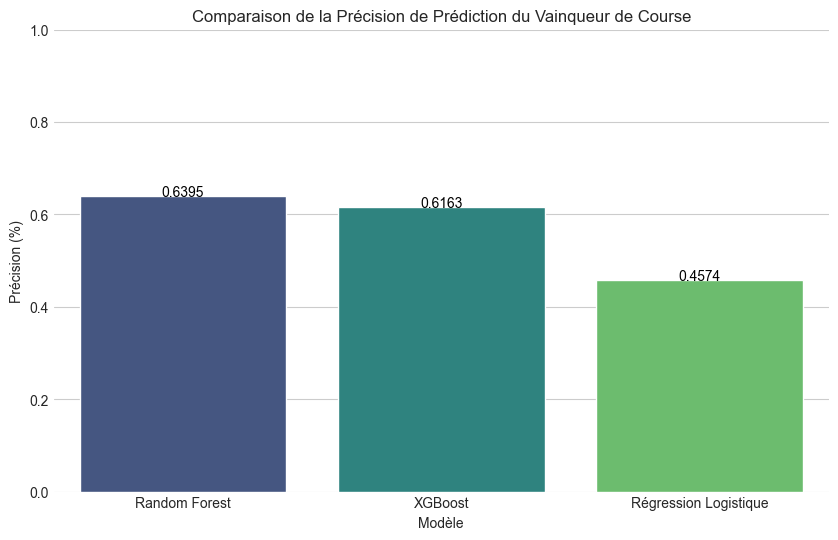

In [ ]:
# Récupérer les métriques de Race Winner Accuracy à partir des résultats précédents
# (Les variables de précision doivent être définies à partir des étapes 5, 8 et 13)

# Les variables attendues sont (ajustez les noms si nécessaire) :
# race_winner_accuracy (RF baseline) ou race_winner_accuracy_tuned (RF tuned)
# race_winner_accuracy_xgb (XGBoost baseline) ou race_winner_accuracy_tuned_xgb (XGBoost tuned)
# race_winner_accuracy_tuned_logreg (LogReg tuned)

comparison_metrics = pd.DataFrame({
    'Modèle': ['Random Forest', 'XGBoost', 'Régression Logistique'],
    'Accuracy Vainqueur de Course': [
        race_winner_accuracy_tuned if 'race_winner_accuracy_tuned' in globals() else race_winner_accuracy,
        race_winner_accuracy_tuned_xgb if 'race_winner_accuracy_tuned_xgb' in globals() else race_winner_accuracy_xgb,
        race_winner_accuracy_tuned_logreg
    ]
})

# Tri par performance
comparison_metrics = comparison_metrics.sort_values(by='Accuracy Vainqueur de Course', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Modèle', y='Accuracy Vainqueur de Course', data=comparison_metrics, palette='viridis')

# Ajout des valeurs au-dessus des barres
for index, row in comparison_metrics.iterrows():
    plt.text(row.name, row['Accuracy Vainqueur de Course'], f"{row['Accuracy Vainqueur de Course']:.4f}", color='black', ha="center")

plt.ylim(0, 1.0)
plt.title('Comparaison de la Précision de Prédiction du Vainqueur de Course')
plt.ylabel('Précision (%)')
plt.show()

#

In [ ]:
# ==============================================================================
# 16. VISUALISATION : COURBE DE CALIBRAGE (Calibration Curve)
# ==============================================================================
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 8))
ax = plt.gca()

for name, probas in models_proba.items():
    if probas is not None:
        # Calcule les fréquences de vrais positifs et les probabilités moyennes
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, probas, n_bins=10)
        ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=name)

ax.plot([0, 1], [0, 1], "k:", label="Parfaitement Calibré") # Ligne idéale

plt.xlabel("Valeur Moyenne Prédite (Mean Predicted Value)")
plt.ylabel("Fraction de Positifs (Fraction of Positives)")
plt.title('Courbe de Calibrage (Reliability Diagram) - Comparaison')
plt.legend(loc="lower right")
plt.show()

#

C:\Users\mathi\AppData\Local\Temp\ipykernel_20076\1251626612.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_xgb.head(top_n).values, y=feature_importances_xgb.head(top_n).index, palette='viridis')


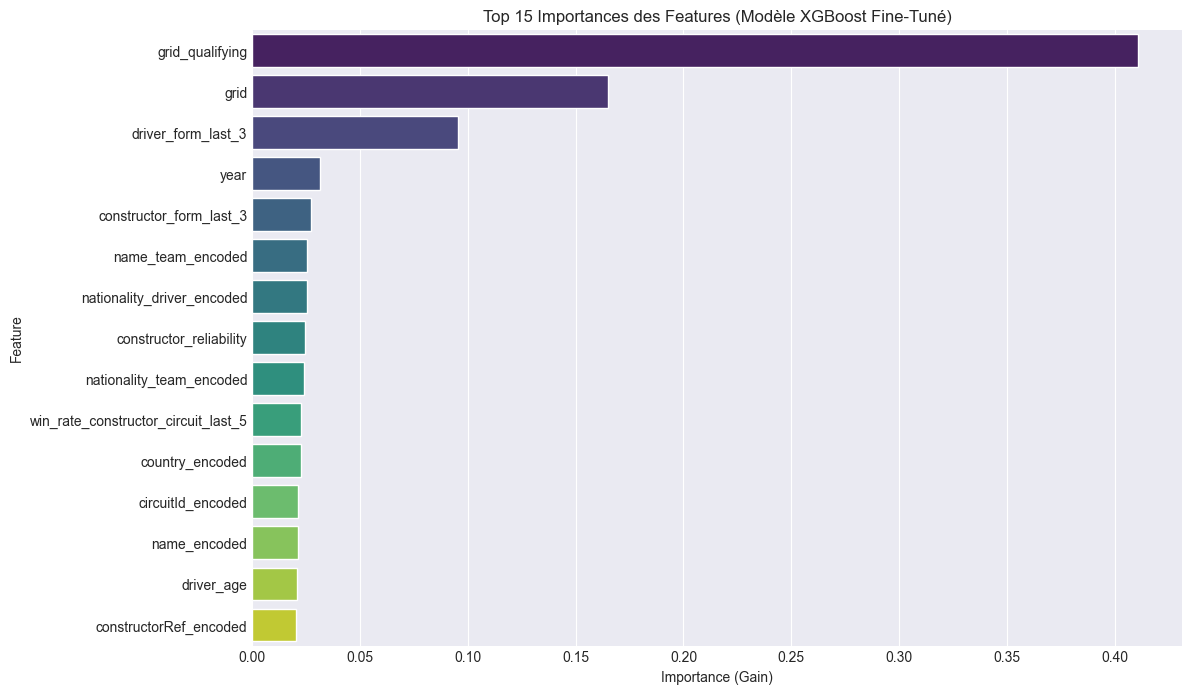

In [ ]:
# ==============================================================================
# 17. VISUALISATION : IMPORTANCE DES FEATURES DU MEILLEUR MODÈLE
# ==============================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assurez-vous que 'best_xgb_model' et 'X_train.columns' sont disponibles
if 'best_xgb_model' in globals() and hasattr(best_xgb_model, 'feature_importances_'):
    feature_importances_xgb = pd.Series(best_xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    top_n = 15 # Afficher les 15 plus importantes

    plt.figure(figsize=(12, 8))
    sns.barplot(x=feature_importances_xgb.head(top_n).values, y=feature_importances_xgb.head(top_n).index, palette='viridis')
    plt.title(f'Top {top_n} Importances des Features (Modèle XGBoost Fine-Tuné)')
    plt.xlabel('Importance (Gain)')
    plt.ylabel('Feature')
    plt.show()

#

Arbre de décision

In [ ]:
# ==============================================================================
# 18.1. RÉGLAGE FIN DU DECISION TREE
# ==============================================================================

# 18.1. Importations Nécessaires
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, log_loss, accuracy_score
import pandas as pd

print("\nDébut du réglage fin (GridSearchCV) pour l'Arbre de Décision...")

# 18.2. Définition du Modèle et de la Grille de Recherche
dt_base = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced' # Gérer le déséquilibre de classe
)

# Grille d'hyperparamètres simple pour pruner l'arbre
param_grid_dt = {
    # Profondeur maximale (limiter la complexité)
    'max_depth': [5, 8, 12, 15, 20, None], # None = pas de limite (overfit)
    # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_split': [2, 5, 10],
    # Critère de qualité de la division
    'criterion': ['gini', 'entropy']
}

# 18.3. Initialisation et Exécution de GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid_dt,
    cv=3,       # 3-fold Validation Croisée
    scoring='f1', # On optimise le F1-Score
    n_jobs=-1,
    verbose=1
)

grid_search_dt.fit(X_train, y_train)

# 18.4. Affichage des Meilleurs Résultats
best_dt_model = grid_search_dt.best_estimator_
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

print("\n=======================================================")
print("✅ RÉGLAGE FIN DECISION TREE TERMINÉ")
print("=======================================================")
print(f"Meilleurs F1-Score de Validation Croisée: {best_score_dt:.4f}")
print("Meilleurs Hyperparamètres trouvés:")
for param, value in best_params_dt.items():
    print(f"- {param}: {value}")


Début du réglage fin (GridSearchCV) pour l'Arbre de Décision...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ RÉGLAGE FIN DECISION TREE TERMINÉ
Meilleurs F1-Score de Validation Croisée: 0.2942
Meilleurs Hyperparamètres trouvés:
- criterion: entropy
- max_depth: 15
- min_samples_split: 2


In [ ]:
# ==============================================================================
# 18.2. ÉVALUATION DU MODÈLE DECISION TREE FINE-TUNÉ
# ==============================================================================

print("\n18.2. Évaluation du Modèle Decision Tree Fine-Tuné sur le Set de Test...")

# 1. Prédictions binaires et probabilités pour le set de test
y_pred_tuned_dt = best_dt_model.predict(X_test)
y_proba_tuned_dt = best_dt_model.predict_proba(X_test)[:, 1]

# 2. Calcul des métriques de classification standard
f1_tuned_dt = f1_score(y_test, y_pred_tuned_dt, average='binary', pos_label=1)
log_loss_tuned_dt = log_loss(y_test, y_proba_tuned_dt)
binary_accuracy_tuned_dt = accuracy_score(y_test, y_pred_tuned_dt)

# 3. Post-traitement pour la Précision du Vainqueur de Course
results_test_tuned_dt = df_test[['raceId', 'constructorId', 'year', 'round']].copy()
results_test_tuned_dt['y_true'] = y_test
results_test_tuned_dt['proba_win'] = y_proba_tuned_dt

predicted_winners_tuned_dt = results_test_tuned_dt.loc[results_test_tuned_dt.groupby('raceId')['proba_win'].idxmax()]
true_winners_tuned_dt = results_test_tuned_dt[results_test_tuned_dt['y_true'] == 1].drop_duplicates(subset=['raceId'], keep='first')

evaluation_df_tuned_dt = predicted_winners_tuned_dt[['raceId', 'constructorId']].rename(
    columns={'constructorId': 'predicted_constructorId'}
)
evaluation_df_tuned_dt = evaluation_df_tuned_dt.merge(
    true_winners_tuned_dt[['raceId', 'constructorId']].rename(columns={'constructorId': 'true_constructorId'}),
    on='raceId',
    how='left'
)

evaluation_df_tuned_dt['is_correct'] = (evaluation_df_tuned_dt['predicted_constructorId'] == evaluation_df_tuned_dt['true_constructorId'])
race_winner_accuracy_tuned_dt = evaluation_df_tuned_dt['is_correct'].mean()


# 4. Affichage des Résultats Finaux
print("\n=======================================================")
print("RÉSUMÉ FINAL DES MÉTRIQUES (Modèle Decision Tree Fine-Tuné)")
print("=======================================================")
print(f"Précision Binaire (Accuracy) : {binary_accuracy_tuned_dt:.4f}")
print(f"F1-Score (pour la classe 'winner') : {f1_tuned_dt:.4f}")
print(f"Log-Loss (Évaluation des probabilités) : {log_loss_tuned_dt:.4f}")
print("\n=======================================================")
print(f"PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : {race_winner_accuracy_tuned_dt:.4f}")
print("=======================================================")

# Affichage des importances des Features
if hasattr(best_dt_model, 'feature_importances_'):
    feature_importances_dt = pd.Series(best_dt_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("\nTop 10 des Caractéristiques les plus importantes (Decision Tree):")
    print(feature_importances_dt.head(10).to_string())


18.2. Évaluation du Modèle Decision Tree Fine-Tuné sur le Set de Test...

RÉSUMÉ FINAL DES MÉTRIQUES (Modèle Decision Tree Fine-Tuné)
Précision Binaire (Accuracy) : 0.9172
F1-Score (pour la classe 'winner') : 0.3028
Log-Loss (Évaluation des probabilités) : 1.4615

PRÉCISION DE L'ÉCURIE GAGNANTE (RACE WINNER ACCURACY) : 0.4729

Top 10 des Caractéristiques les plus importantes (Decision Tree):
grid_qualifying            0.525588
grid                       0.085673
driver_age                 0.070328
driver_form_last_3         0.056806
constructor_reliability    0.051534
year                       0.042662
constructor_form_last_3    0.031131
name_encoded               0.021987
alt                        0.020991
country_encoded            0.017909


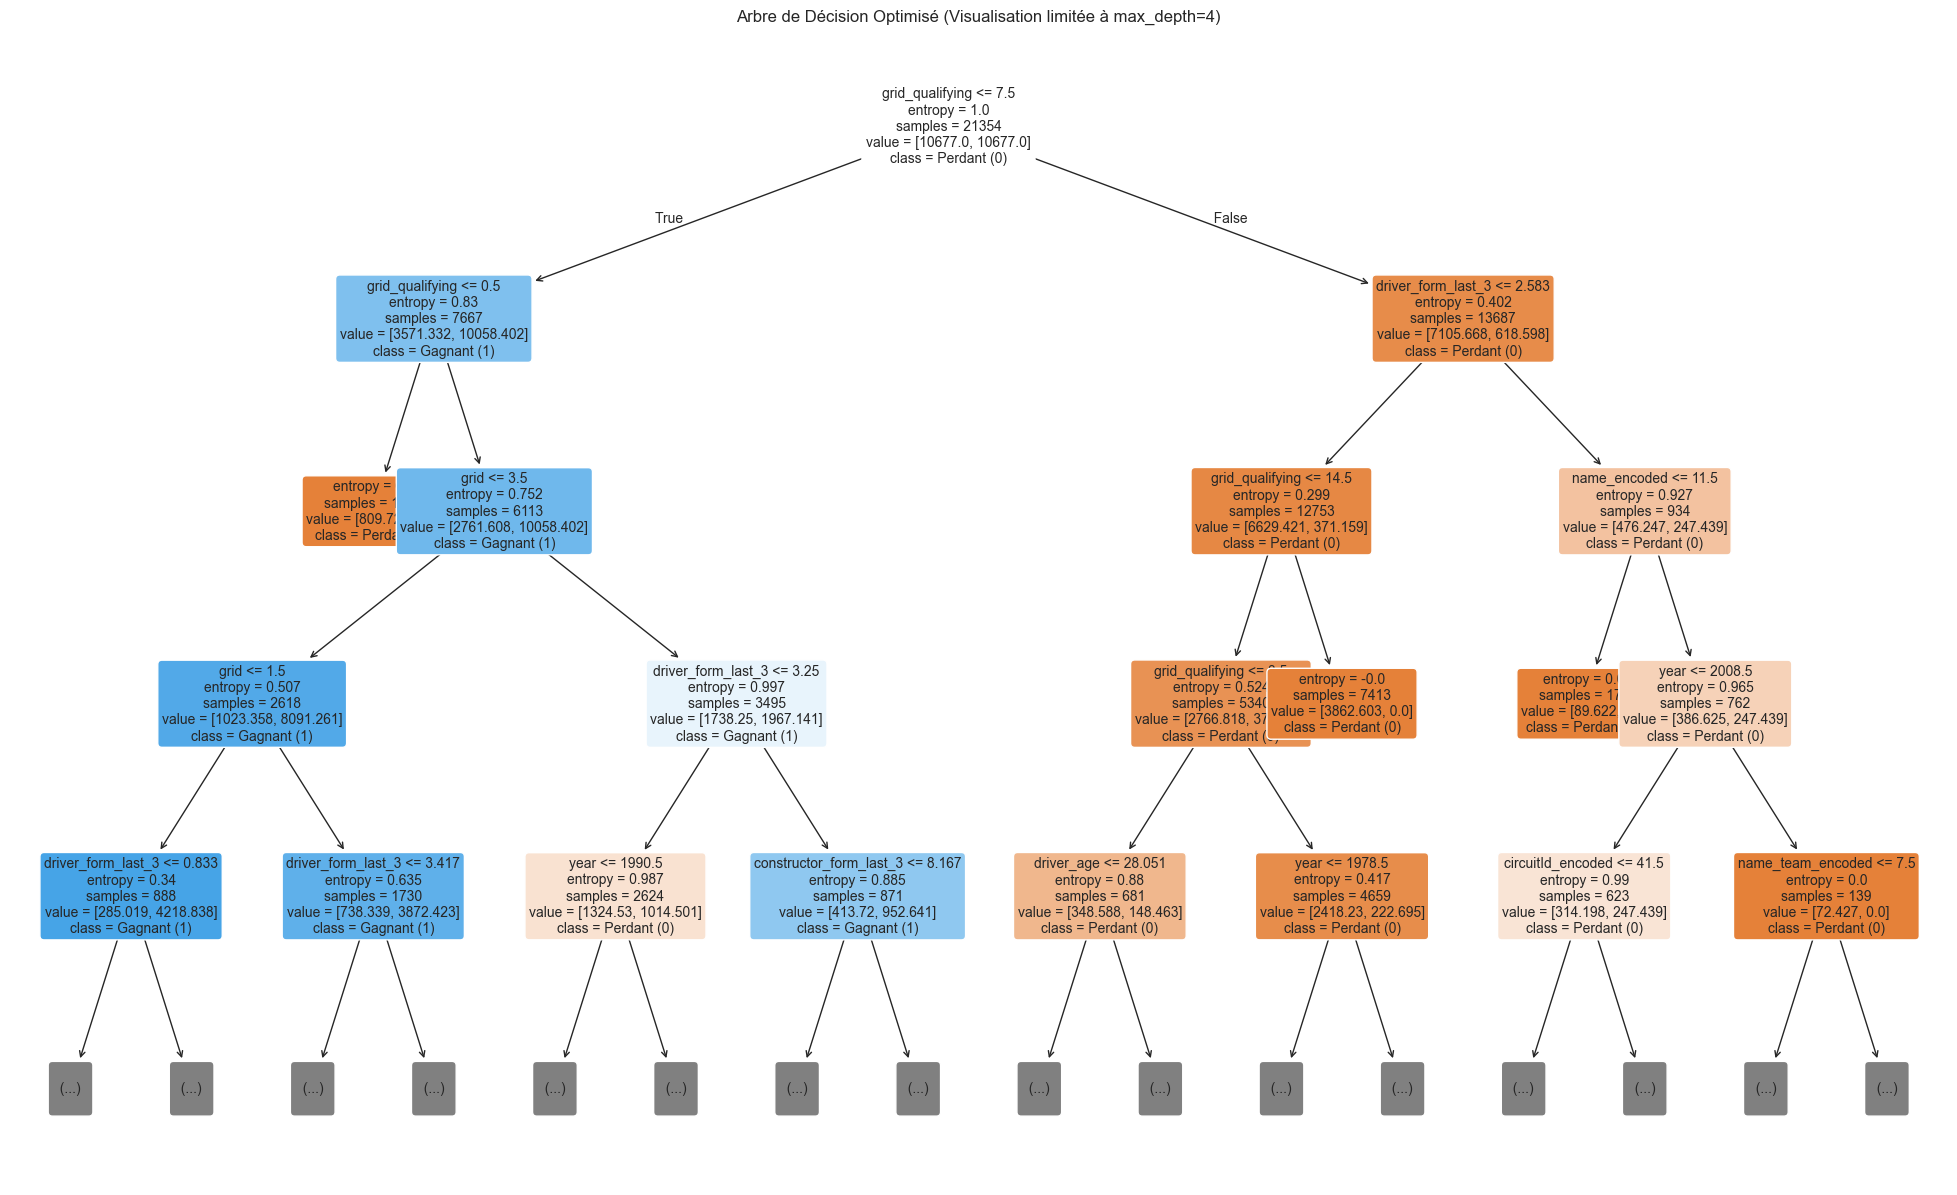

✅ Visualisation de l'Arbre de Décision (jusqu'à la profondeur 4) affichée et enregistrée sous 'decision_tree_viz.png'.


In [ ]:
# ==============================================================================
# 19. VISUALISATION DE L'ARBRE DE DÉCISION OPTIMISÉ
# ==============================================================================
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assurez-vous que 'best_dt_model' (le modèle trouvé après la Grid Search)
# et 'X_train' (le DataFrame de features d'entraînement) sont définis et disponibles.

plt.figure(figsize=(25, 15))

# Limiter la profondeur pour que l'image soit lisible dans le notebook
# Si l'arbre optimal a une profondeur max_depth supérieure, seules les 4 premières divisions seront affichées.
max_depth_to_plot = 4

plot_tree(
    best_dt_model,
    feature_names=X_train.columns.tolist(),
    class_names=['Perdant (0)', 'Gagnant (1)'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=max_depth_to_plot # Limite la profondeur pour une meilleure visualisation
)

plt.title(f"Arbre de Décision Optimisé (Visualisation limitée à max_depth={max_depth_to_plot})")
plt.savefig('decision_tree_viz.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Visualisation de l'Arbre de Décision (jusqu'à la profondeur {max_depth_to_plot}) affichée et enregistrée sous 'decision_tree_viz.png'.")